In [1]:
import talib
import vectorbt as vbt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime,timedelta
import time
import gc
import backtesting as bt

C:\Users\shiv\anaconda3\envs\pt\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
data_1m=(pd.read_csv('BTC_1m_2020_to_12-2-2024.csv',index_col="date",parse_dates=True)).loc['2023'].copy().rename(columns={"open":"Open","high":"High","low":"Low","close":'Close',"volume":"Volume"})
data=(data_1m.resample("60T",closed='right').agg({"Open":'first',"High":'max',"Low":'min','Close':'last',"Volume":'sum'})).dropna()
data.index=data.index+timedelta(hours=1)


In [3]:
def Provide_result(df_1min,df):
    for x in df.columns:
        df_1min[x]=0
        pos=df[x]
        idx=df_1min.loc[df_1min.index.isin(df.index)].index
        df_1min.loc[idx,x]=pos.loc[idx]
#     print('df_5min',df_1min[df.columns])
    pf_vbt = vbt.Portfolio.from_signals(df_1min.Close, low=df_1min.Low, high=df_1min.High,
                                               open=df_1min.Open, entries=df_1min[list(df.columns)] == 1, short_entries=df_1min[list(df.columns)] == -1,
                                               sl_stop=0.05, tp_stop=0.051,
                                               init_cash=100000, freq='1m')
    pf_return=pf_vbt.total_return()
    return({"max":pf_return.nlargest(1),"min":pf_return.nsmallest(1)}) 

def optimize_ma(df_1min,df_5min,i_range=range(2,20,2)):
    df_list=[]
    for i in i_range:
        sma_14= talib.SMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where((df_5min['Close'] > sma_14)&(df_5min.Close.shift(1)<=(df_5min.Close)), 1,
                                                     np.where((df_5min['Close'] < sma_14) & (df_5min.Close.shift(1)>=(df_5min.Close)), -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_adx(df_1min,df_5min,i_range=range(2,20,2)):
    df_list=[]
    for i in i_range:
        adx = talib.ADX(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(adx > 80, 1, np.where(adx < 30, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_aroonosc(df_1min,df_5min,i_range=range(2,20,2),j_range=range(30,91,10)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            aroonosc = talib.AROONOSC(df_5min['High'], df_5min['Low'], timeperiod=i)
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(aroonosc > j, 1,np.where(aroonosc < j-20, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_atr(df_1min,df_5min,i_range=range(10,20,2),j_range=range(10,30,5)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            atr = talib.ATR(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
            atr_ma=atr.rolling(j).mean()
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(atr > atr_ma, 1, np.where(atr < atr_ma, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_apo(df_1min,df_5min,i_range=range(2,20,2),j_range=range(10,21,3)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            apo = talib.APO(df_5min['Close'], fastperiod=i, slowperiod=j, matype=0)
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(apo > 100, 1, np.where(apo < -100, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_avgprice(df_1min,df_5min,i_range=np.arange(0,0.20,0.01)):
    df_list=[]
    for i in i_range:
        avgprice = talib.AVGPRICE(df_5min['Open'], df_5min['High'], df_5min['Low'], df_5min['Close'])
        df_list.append(pd.DataFrame({f"{i}":np.where(df_5min['Close'] > avgprice*(1+i), 1, 0)+np.where(df_5min['Close'] < avgprice*(1-i), -1, 0)},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_bbands(df_1min,df_5min,i_range=range(5,30,4),j_range=range(2,5,1),k_range=range(2,5,1)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            for k in j_range:
                bbands_upper, _, bbands_Lower = talib.BBANDS(df_5min['Close'], timeperiod=i, nbdevup=j, nbdevdn=j, matype=0)
                df_list.append(pd.DataFrame({f"{i}_{j}_{k}":np.where(df_5min['Close'] < bbands_Lower, -1, 0) +  np.where(df_5min['Close'] > bbands_upper, 1, 0)},
                                            index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_beta(df_1min,df_5min,i_range=range(2,30,3)):
    df_list=[]
    for i in i_range:
        beta=talib.BETA(df_5min['High'], df_5min['Low'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(beta > 0, -1, np.where( beta < 0, 1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_bop(df_1min,df_5min,i_range=range(2,10,2)):
    df_list=[]
    for i in i_range:
        bop=talib.BOP(df_5min['Open'], df_5min['High'], df_5min['Low'], df_5min['Close'])
        bop_ma=bop.rolling(i).mean()
        df_list.append(pd.DataFrame({f"{i}":np.where(bop > bop_ma, 1, np.where(bop < bop_ma, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_cci(df_1min,df_5min,i_range=range(2,40,4),j_range=range(0,401,100)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            cci = talib.CCI(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
            df_list.append(pd.DataFrame({f"{i}_{j}": np.where(cci > j, 1, np.where(cci< -j, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_dema(df_1min,df_5min,i_range=range(2,40,4)):
    df_list=[]
    for i in i_range:
        dema = talib.DEMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(dema > dema.shift(1), 1,np.where(dema < dema.shift(1), -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_dx(df_1min,df_5min,i_range=range(2,40,4),j_range=range(0,51,10)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            dx = talib.DX(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(dx > 50+j, 1, np.where(dx < 50-j, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_ema(df_1min,df_5min,i_range=range(2,40,4)):
    df_list=[]
    for i in i_range:
        ema = talib.EMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(df_5min['Close'] > ema, 1, np.where(df_5min['Close'] < ema, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_natr(df_1min,df_5min,i_range=range(2,80,5),j_range=range(2,20,4)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            natr = talib.NATR(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
            natr_ma= natr.rolling(j).mean()
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(natr > natr_ma, -1, np.where(natr < natr_ma, 1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_obv(df_1min,df_5min,i_range=range(2,20,4)):
    df_list=[]
    for i in i_range:
        obv = talib.OBV(df_5min['Close'], df_5min['Volume'])
        obv_ma=obv.rolling(i).mean()
        df_list.append(pd.DataFrame({f"{i}":np.where(obv >obv_ma , 1, np.where(obv < obv_ma, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_plus_dm(df_1min,df_5min,i_range=range(2,70,5),j_range=range(2,20,4)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            plus_dm = talib.PLUS_DM(df_5min['High'], df_5min['Low'], timeperiod=i)
            plus_dm_ma= plus_dm.rolling(j).mean()
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(plus_dm > plus_dm_ma, 1, np.where(plus_dm <plus_dm_ma , -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_ppo(df_1min,df_5min,i_range=range(3,30,4),j_range=range(12,50,6),k_range=range(2,25,4)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            for k in j_range:
                ppo = talib.PPO(df_5min['Close'], fastperiod=i, slowperiod=j, matype=0)
                ppo_ma=ppo.rolling(k).mean()
                df_list.append(pd.DataFrame({f"{i}_{j}_{k}":np.where(ppo > ppo_ma, 1, np.where(ppo < ppo_ma, -1, 0))},
                                            index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_roc(df_1min,df_5min,i_range=range(2,30,4)):
    df_list=[]
    for i in i_range:
        roc = talib.ROC(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(roc > 1, 1, np.where(roc < -1, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_rsi(df_1min,df_5min,i_range=range(2,30,4)):
    df_list=[]
    for i in i_range:
        rsi = talib.RSI(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(rsi > 70, 1, np.where(rsi < 30, -1, 0))},index=df_5min.index))      
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_sar(df_1min,df_5min,i_range=np.arange(0.005,0.05,0.005),j_range=np.arange(0.1,0.7,0.1)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            sar = talib.SAR(df_5min['High'], df_5min['Low'], acceleration=i, maximum=j)
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(df_5min['Close'] > sar, 1,np.where( df_5min['Close'] < sar,-1,0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_deviation(df_1min,df_5min,i_range=range(2,39,4),j_range=range(1,4,1)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            stddev = talib.STDDEV(df_5min['Close'], timeperiod=i, nbdev=j)
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(((stddev/df_5min.Close)>0.006)&(df_5min.Close>df_5min.Close.shift(1)), 1,
                                                             np.where(((stddev/df_5min.Close)>0.006) & (df_5min.Close<df_5min.Close.shift(1)),-1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_stoch(df_1min,df_5min,i_range=range(3,40,4),j_range=range(2,10,2),k_range=range(2,10,2)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            for k in j_range:
                stoch_slowk, stoch_slowd = talib.STOCH(df_5min['High'], df_5min['Low'], df_5min['Close'], fastk_period=i, slowk_period=j, slowd_period=k)
                df_list.append(pd.DataFrame({f"{i}_{j}_{k}":np.where((stoch_slowk > stoch_slowd) & (stoch_slowk.shift(1) <= stoch_slowd.shift(1)), 1,
                                       np.where((stoch_slowk < stoch_slowd) & (stoch_slowk.shift(1) >= stoch_slowd.shift(1)), -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_t3(df_1min,df_5min,i_range=range(2,29,3),j_range=range(2,25,4)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            t3 = talib.T3(df_5min['Close'], timeperiod=i, vfactor=0)     
            t3_ma=t3.rolling(j).mean()
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where(t3 > t3_ma, 1, np.where(t3 < t3_ma, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_tema(df_1min,df_5min,i_range=range(2,60,6)):
    df_list=[]
    for i in i_range:
        tema = talib.TEMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(df_5min['Close'] > tema, 1, np.where(df_5min['Close'] < tema, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_trange(df_1min,df_5min,i_range=range(2,60,6)):
    df_list=[]
    for i in i_range:
        trange = talib.TRANGE(df_5min['High'], df_5min['Low'], df_5min['Close'])
        trange_ma=trange.rolling(i).mean()
        df_list.append(pd.DataFrame({f"{i}": np.where(trange > trange_ma, -1, np.where(trange < trange_ma, 1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_trima(df_1min,df_5min,i_range=range(2,30,3)):
    df_list=[]
    for i in i_range:
        trima = talib.TRIMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(df_5min['Close'] > 1.01*trima, 1, np.where(df_5min['Close'] < 0.99*trima, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_trix(df_1min,df_5min,i_range=range(2,29,4),j_range=range(2,35,4)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            trix = talib.TRIX(df_5min['Close'], timeperiod=i)
            trix_ma=df_5min.Close.rolling(j).mean()
            df_list.append(pd.DataFrame({f"{i}_{j}":np.where((trix > 0.15)&(trix_ma<trix), 1, np.where((trix < -0.15) & (trix_ma>trix), -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_tsf(df_1min,df_5min,i_range=range(2,40,3)):
    df_list=[]
    for i in i_range:
        tsf = talib.TSF(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}": np.where(df_5min['Close'] > 1.01*tsf, 1, np.where(df_5min['Close'] < 0.99*tsf, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_ultosc(df_1min,df_5min,i_range=range(3,16,3),j_range=range(8,30,4),k_range=range(16,50,7)):
    df_list=[]
    for i in i_range:
        for j in j_range:
            for k in j_range:
                ultosc = talib.ULTOSC(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod1=i, timeperiod2=j, timeperiod3=k)
                df_list.append(pd.DataFrame({f"{i}_{j}_{k}":np.where(ultosc > 1.27*ultosc.shift(1), 1, np.where(ultosc < 0.73*ultosc.shift(1), -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_willr(df_1min,df_5min,i_range=range(2,40,3)):
    df_list=[]
    for i in i_range:
        willr = talib.WILLR(df_5min['High'], df_5min['Low'], df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}": np.where(willr > -20, 1, np.where(willr < -80, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))

def optimize_wma(df_1min,df_5min,i_range=range(2,40,3)):
    df_list=[]
    for i in i_range:
        wma = talib.WMA(df_5min['Close'], timeperiod=i)
        df_list.append(pd.DataFrame({f"{i}":np.where(df_5min['Close'] > wma, 1, np.where(df_5min['Close'] < wma, -1, 0))},index=df_5min.index))
    return(Provide_result(df_1min,pd.concat(df_list,axis=1)))


In [4]:
optimization_list={
    "sma":optimize_ma,"adx":optimize_adx,"aroonosc":optimize_aroonosc,"atr":optimize_atr,"apo":optimize_apo,
    "avgprice":optimize_avgprice,"bbands":optimize_bbands,
    "beta":optimize_beta,"bop":optimize_bop,"cci_signals":optimize_cci,"dema":optimize_dema,
    "dx":optimize_dx,"ema":optimize_ema,"natr":optimize_natr,
    "obv":optimize_obv,"plus_dm":optimize_plus_dm,"ppo":optimize_ppo,"roc":optimize_roc,
    "rsi":optimize_rsi,"sar":optimize_sar,"stddev":optimize_deviation,
    "stoch_slowk":optimize_stoch,"t3":optimize_t3,"tema":optimize_tema,"trange":optimize_trange,
    "trima":optimize_trima,"trix":optimize_trix,"tsf":optimize_tsf,
    "ultosc":optimize_ultosc,"willr":optimize_willr,"wma":optimize_wma
}
# dic={}
# for i in optimization_list.keys():
#     dic[i]=(optimization_list[i](data_1m.copy(),data.copy()))

In [5]:
def Other_indicater(data):
    signal=pd.DataFrame(index=data.index)
    ad = talib.AD(data['High'], data['Low'], data['Close'], data['Volume'])
    signal['ad']=np.where(ad > ad.shift(1), 1, np.where(ad < ad.shift(1), -1, 0))
    adosc = talib.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=10)
    signal['adosc']=np.where(adosc > 0, 1, -1)
    adxr = talib.ADXR(data['High'], data['Low'], data['Close'], timeperiod=25)
    signal["adxr"] = np.where(adxr > 80, 1, np.where(adxr < 20, -1, 0))
    aroon_down, aroon_up = talib.AROON(data['High'], data['Low'], timeperiod=26)
    signal['arroon']=np.where(aroon_up > 0, -1,np.where(aroon_down > 0, 1, 0))
    ht_dcperiod = talib.HT_DCPERIOD(data['Close'])
    signal['ht_dcperiod'] = np.where(ht_dcperiod > 30, 1, np.where(ht_dcperiod < 20, -1, 0))
    ht_phasor_inphase, ht_phasor_quadrature = talib.HT_PHASOR(data['Close'])
    signal['ht_phasor_inphase']= np.where((ht_phasor_inphase > ht_phasor_quadrature), -1, np.where((ht_phasor_inphase < ht_phasor_quadrature), 1, 0))
    ht_sine, ht_leadsine = talib.HT_SINE(data['Close'])
    signal['ht_sine'] = np.where((ht_sine > ht_leadsine) & (ht_sine.shift(1) <= ht_leadsine.shift(1)), 1, np.where((ht_sine < ht_leadsine) & (ht_sine.shift(1) >= ht_leadsine.shift(1)), -1, 0))
    plus_di = talib.PLUS_DI(data['High'], data['Low'], data['Close'], timeperiod=2)
    signal['plus_di'] = np.where(plus_di > 35, 1, np.where(plus_di < 25, -1, 0))
    rocp = talib.ROCP(data['Close'], timeperiod=31)
    signal['rocp'] = np.where(rocp > 0.02, 1, np.where(rocp < -0.02, -1, 0))
    rocr = talib.ROCR(data['Close'], timeperiod=30)
    signal['rocr'] = np.where(rocr > 1.02, 1, np.where(rocr < 0.98, -1, 0))
    sarext = talib.SAREXT(data['High'], data['Low'], startvalue=0, offsetonreverse=0, accelerationinitlong=0.03, accelerationlong=0.03, accelerationmaxlong=0.3, accelerationinitshort=0.03, accelerationshort=0.03, accelerationmaxshort=0.3)
    signal['sarext'] = np.where(data['Close'] > 1.02*sarext, -1,np.where(data['Close'] < 0.98*sarext,1,0))
    stochf_fastk, stochf_fastd = talib.STOCHF(data['High'], data['Low'], data['Close'], fastk_period=5, fastd_period=3, fastd_matype=0)
    signal['stochf_fastk'] = np.where((stochf_fastk > stochf_fastd) & (stochf_fastk.shift(1) <= stochf_fastd.shift(1)), 1, np.where((stochf_fastk < stochf_fastd) & (stochf_fastk.shift(1) >= stochf_fastd.shift(1)), -1, 0))
    stochrsi_fastk, stochrsi_fastd = talib.STOCHRSI(data['Close'], timeperiod=7, fastk_period=5, fastd_period=3, fastd_matype=0)
    signal['stochrsi_fastk'] = np.where((stochrsi_fastk > stochrsi_fastd) & (stochrsi_fastk.shift(1) <= stochrsi_fastd.shift(1)), 1, np.where((stochrsi_fastk < stochrsi_fastd) & (stochrsi_fastk.shift(1) >= stochrsi_fastd.shift(1)), -1, 0))
    typprice = talib.TYPPRICE(data['High'], data['Low'], data['Close'])
    signal['typprice'] = np.where(typprice > 1.01*typprice.shift(1), 1, np.where(typprice < 0.99*typprice.shift(1), -1, 0))
    wclprice = talib.WCLPRICE(data['High'], data['Low'], data['Close'])
    signal['wclprice'] = np.where(wclprice > 1.01*wclprice.shift(1), 1, np.where(wclprice < 0.99*wclprice.shift(1), -1, 0))
    return(signal)

def One_trade_only(df,sig,req_vote=1,min_hour=0,max_hour=23):
    final_df=pd.DataFrame(np.array(sig))
    final_df.index=df.index
    final_df.rename(columns={0:'sig'},inplace=True)
    final_df["zero"]=0
    start=final_df.index[0]
    end=final_df.index[-1]
    for ind in pd.date_range(start,end+timedelta(days=0)):
        d=final_df.loc[str(ind.date())]
        if  len(d)!=0:
            bear=(d.index[(d.sig<=(-req_vote))&(d.index.hour>=min_hour)&(d.index.hour<=max_hour)])
            bull=(d.index[(d.sig>=req_vote)&(d.index.hour>=min_hour)&(d.index.hour<=max_hour)])
            if (len(bear)!=0) & (len(bull)!=0):
                if bull[0]<bear[0]:
                    final_df.loc[bull[0],"zero"]=1
                elif bear[0]<bull[0]:
                    final_df.loc[bear[0],"zero"]=-1   
            elif len(bear)!=0:
                final_df.loc[bear[0],'zero']=-1
            elif len(bull)!=0:
                final_df.loc[bull[0],'zero']=1
    return((final_df.zero))

In [6]:
def Candelstick_indicater(data):
    signal=pd.DataFrame(index=data.index)
    cdl_2crows = talib.CDL2CROWS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_2crows_signals'] = np.where(cdl_2crows> 0, 1, np.where(cdl_2crows < 0, -1, 0))
    cdl_3blackcrows = talib.CDL3BLACKCROWS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_3blackcrows_signals'] = np.where(cdl_3blackcrows > 0, 1, np.where(cdl_3blackcrows < 0, -1, 0))
    cdl_3inside = talib.CDL3INSIDE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_3inside_signals'] = np.where(cdl_3inside > 0, -1, np.where(cdl_3inside < 0, 1, 0))
    cdl_3linestrike = talib.CDL3LINESTRIKE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_3linestrike']=np.where(cdl_3linestrike>0,1,np.where(cdl_3linestrike<0,-1,0))
    cdl_3outside = talib.CDL3OUTSIDE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_3outside']=np.where(cdl_3outside>0,1,np.where(cdl_3outside<0,-1,0))
    cdl_3whitesoldiers = talib.CDL3WHITESOLDIERS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_3whitesoldiers']=np.where(cdl_3whitesoldiers>0,-1,np.where(cdl_3whitesoldiers<0,1,0))
    cdl_advanceblock = talib.CDLADVANCEBLOCK(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_advanceblock']=np.where(cdl_advanceblock>0,1,np.where(cdl_advanceblock<0,-1,0))
    cdl_belthold = talib.CDLBELTHOLD(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_belthold']=np.where(cdl_belthold>0,-1,np.where(cdl_belthold<0,1,0))
    cdl_breakaway = talib.CDLBREAKAWAY(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_breakaway']=np.where(cdl_breakaway>0,1,np.where(cdl_breakaway<0,-1,0))
    cdl_closingmarubozu = talib.CDLCLOSINGMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_closingmarubozu']=np.where(cdl_closingmarubozu>0,-1,np.where(cdl_closingmarubozu<0,1,0))
    CDLDOJI = talib.CDLDOJI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['CDLDOJI']=np.where(CDLDOJI>0,-1,np.where(CDLDOJI<0,1,0))
    cdl_dojistar = talib.CDLDOJISTAR(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_dojistar']=np.where(cdl_dojistar>0,1,np.where(cdl_dojistar<0,-1,0))
    cdl_dragonflydoji = talib.CDLDRAGONFLYDOJI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_dragonflydoji']=np.where(cdl_dragonflydoji>0,-1,np.where(cdl_dragonflydoji<0,1,0))
    cdl_engulfing = talib.CDLENGULFING(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_engulfing']=np.where(cdl_engulfing>0,1,np.where(cdl_engulfing<0,-1,0))
    cdl_eveningstar = talib.CDLEVENINGSTAR(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_eveningstar']=np.where(cdl_eveningstar>0,1,np.where(cdl_eveningstar<0,-1,0))
    cdl_gapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_gapsidesidewhite']=np.where(cdl_gapsidesidewhite>0,1,np.where(cdl_gapsidesidewhite<0,-1,0))
    cdl_gravestonedoji = talib.CDLGRAVESTONEDOJI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_gravestonedoji']=np.where(cdl_gravestonedoji>0,-1,np.where(cdl_gravestonedoji<0,1,0))
    cdl_hammer = talib.CDLHAMMER(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_hammer']=np.where(cdl_hammer>0,-1,np.where(cdl_hammer<0,1,0))
    cdl_hangingman = talib.CDLHANGINGMAN(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_hangingman']=np.where(cdl_hangingman>0,1,np.where(cdl_hangingman<0,-1,0))
    cdl_harami = talib.CDLHARAMI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_harami']=np.where(cdl_harami>0,1,np.where(cdl_harami<0,-1,0))
    cdl_haramicross = talib.CDLHARAMICROSS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_haramicross']=np.where(cdl_haramicross>0,1,np.where(cdl_haramicross<0,-1,0))
    cdl_Highwave = talib.CDLHIGHWAVE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_Highwave']=np.where(cdl_Highwave>0,-1,np.where(cdl_Highwave<0,1,0))
    cdl_hikkake = talib.CDLHIKKAKE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_hikkake']=np.where(cdl_hikkake>0,1,np.where(cdl_hikkake<0,-1,0))
    cdl_hikkakemod = talib.CDLHIKKAKEMOD(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_hikkakemod']=np.where(cdl_hikkakemod>100,-1,np.where(cdl_hikkakemod<-100,1,0))
    cdl_homingpigeon = talib.CDLHOMINGPIGEON(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_homingpigeon']=np.where(cdl_homingpigeon>0,1,np.where(cdl_homingpigeon<0,-1,0))
    cdl_identical3crows = talib.CDLIDENTICAL3CROWS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_identical3crows']=np.where(cdl_identical3crows>0,-1,np.where(cdl_identical3crows<0,1,0))
    cdl_inneck = talib.CDLINNECK(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_inneck']=np.where(cdl_inneck>0,-1,np.where(cdl_inneck<0,1,0))
    cdl_invertedhammer = talib.CDLINVERTEDHAMMER(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_invertedhammer']=np.where(cdl_invertedhammer>0,1,np.where(cdl_invertedhammer<0,-1,0))
    cdl_ladderbottom = talib.CDLLADDERBOTTOM(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_ladderbottom']=np.where(cdl_ladderbottom>0,-1,np.where(cdl_ladderbottom<0,1,0))
    cdl_longleggeddoji = talib.CDLLONGLEGGEDDOJI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_longleggeddoji']=np.where(cdl_longleggeddoji>0,-1,np.where(cdl_longleggeddoji<0,1,0))
    cdl_longline = talib.CDLLONGLINE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_longline']=np.where(cdl_longline>0,-1,np.where(cdl_longline<0,1,0))
    cdl_marubozu = talib.CDLMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_marubozu']=np.where(cdl_marubozu>0,-1,np.where(cdl_marubozu<0,1,0))
    cdl_matchingLow = talib.CDLMATCHINGLOW(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_matchingLow']=np.where(cdl_matchingLow>0,-1,np.where(cdl_matchingLow<0,1,0))
    cdl_morningdojistar = talib.CDLMORNINGDOJISTAR(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_morningdojistar']=np.where(cdl_morningdojistar>0,1,np.where(cdl_morningdojistar<0,-1,0))
    
    cdl_onneck = talib.CDLONNECK(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_onneck']=np.where(cdl_onneck>0,-1,np.where(cdl_onneck<0,1,0))
    cdl_piercing = talib.CDLPIERCING(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_piercing']=np.where(cdl_piercing>0,-1,np.where(cdl_piercing<0,1,0))
    cdl_rickshawman = talib.CDLRICKSHAWMAN(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_rickshawman']=np.where(cdl_rickshawman>0,-1,np.where(cdl_rickshawman<0,1,0))
    cdl_risefall3methods = talib.CDLRISEFALL3METHODS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_risefall3methods']=np.where(cdl_risefall3methods>0,-1,np.where(cdl_risefall3methods<0,1,0))
    
    cdl_shootingstar = talib.CDLSHOOTINGSTAR(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_shootingstar']=np.where(cdl_shootingstar>0,1,np.where(cdl_shootingstar<0,-1,0))
    cdl_shortline = talib.CDLSHORTLINE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_shortline']=np.where(cdl_shortline>0,-1,np.where(cdl_shortline<0,1,0))
    cdl_spinningtop = talib.CDLSPINNINGTOP(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_spinningtop']=np.where(cdl_spinningtop>0,-1,np.where(cdl_spinningtop<0,1,0))
    cdl_sticksandwich = talib.CDLSTICKSANDWICH(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_sticksandwich']=np.where(cdl_sticksandwich>0,1,np.where(cdl_matchingLow<0,-1,0))
    cdl_takuri = talib.CDLTAKURI(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_takuri']=np.where(cdl_takuri>0,-1,np.where(cdl_takuri<0,1,0))
    cdl_tasukigap = talib.CDLTASUKIGAP(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_tasukigap']=np.where(cdl_tasukigap>0,-1,np.where(cdl_tasukigap<0,1,0))
    cdl_thrusting = talib.CDLTHRUSTING(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_thrusting']=np.where(cdl_thrusting>0,-1,np.where(cdl_thrusting<0,1,0))
    cdl_tristar = talib.CDLTRISTAR(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_tristar']=np.where(cdl_tristar>0,1,np.where(cdl_tristar<0,-1,0))
    cdl_unique3river = talib.CDLUNIQUE3RIVER(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_unique3river']=np.where(cdl_unique3river>0,-1,np.where(cdl_unique3river<0,1,0))
    cdl_xsidegap3methods = talib.CDLXSIDEGAP3METHODS(data['Open'], data['High'], data['Low'], data['Close'])
    signal['cdl_xsidegap3methods']=np.where(cdl_xsidegap3methods>0,1,np.where(cdl_xsidegap3methods<0,-1,0))
    return(signal)

In [7]:
def best_parameter(dic_key):
    sign=np.sign(dic_key['max'][0]+dic_key['min'][0])
    if sign==1:
        perameter_value=dic_key['max'].index[0].split("_")
    elif sign==-1:
        perameter_value=dic_key['min'].index[0].split("_")
    else:
        sign=1
        perameter_value=dic_key['max'].index[0].split("_")
    return(perameter_value,sign)
def Optimizable_indicater(data,dic):
    signal=pd.DataFrame(index=data.index)
    
    adx_value,adx_sign=best_parameter(dic['adx'])
    adx = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=int(adx_value[0]))
    signal['adx'] = np.where(adx > 80, int(adx_sign)*1, np.where(adx < 30, int(adx_sign)*-1, 0))
    
    
    apo_value,apo_sign=best_parameter(dic['apo'])
    apo = talib.APO(data['Close'], fastperiod=int(apo_value[0]), slowperiod=int(apo_value[1]), matype=0)
    signal['apo'] = np.where(apo > 100, int(apo_sign)*1, np.where(apo < -100, int(apo_sign)*-1, 0))
    
    
    aroonosc_value,aroonosc_sign=best_parameter(dic['aroonosc'])
    aroonosc = talib.AROONOSC(data['High'], data['Low'], timeperiod=int(aroonosc_value[0]))
    signal['aroonosc']=np.where(aroonosc > int(aroonosc_value[1]), int(aroonosc_sign)*1,np.where(aroonosc < (int(aroonosc_value[1])-20),int(aroonosc_sign)*-1, 0))

    
    atr_value,atr_sign=best_parameter(dic['atr'])
    atr = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=int(atr_value[0]))
    atr_ma=atr.rolling(int(atr_value[1])).mean()
    signal['atr']=np.where(atr > atr_ma,int(atr_sign)* 1, np.where(atr < atr_ma, int(atr_sign)* -1, 0))

    
    avgprice_value,avgprice_sign=best_parameter(dic['avgprice'])
    avgprice = talib.AVGPRICE(data['Open'], data['High'], data['Low'], data['Close'])
    signal['avgprice']=np.where(data['Close'] > avgprice*(1+float(avgprice_value[0])),int(avgprice_sign) *1, 0)+np.where(data['Close'] < avgprice*(1-float(avgprice_value[0])),int(avgprice_sign) * -1, 0)
 

    bbands_value,bbands_sign=best_parameter(dic['bbands'])
    bbands_upper, _, bbands_Lower = talib.BBANDS(data['Close'], timeperiod=int(bbands_value[0]), nbdevup=int(bbands_value[1]), nbdevdn=int(bbands_value[2]), matype=0)
    signal['bbands']=np.where(data['Close'] < bbands_Lower, int(bbands_sign)*-1, 0) +  np.where(data['Close'] > bbands_upper,int(bbands_sign)* 1, 0)

    
    beta_value,beta_sign=best_parameter(dic['beta'])
    beta=talib.BETA(data['High'], data['Low'], timeperiod=int(beta_value[0]))
    signal['beta'] = np.where(beta > 0, int(beta_sign)*-1, np.where( beta < 0, int(beta_sign)*1, 0))

    
    bop_value,bop_sign=best_parameter(dic['bop'])
    bop=talib.BOP(data['Open'], data['High'], data['Low'], data['Close'])
    bop_ma=bop.rolling(int(bop_value[0])).mean()
    signal['bop']=np.where(bop > bop_ma,int(bop_sign)* 1, np.where(bop < bop_ma,int(bop_sign)* -1, 0))

    
    cci_signals_value,cci_signals_sign=best_parameter(dic['cci_signals'])
    cci = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=int(cci_signals_value[0]))
    signal["cci_signals"] =np.where(cci > int(cci_signals_value[1]),int(cci_signals_sign)* 1, np.where(cci< -int(cci_signals_value[1]),int(cci_signals_sign)* -1, 0))
  

    dema_value,dema_sign=best_parameter(dic['dema'])
    dema = talib.DEMA(data['Close'], timeperiod=int(dema_value[0]))
    signal['dema']=np.where(dema > dema.shift(1),int(dema_sign)* 1,np.where(dema < dema.shift(1),int(dema_sign)* -1, 0))

    
    dx_value,dx_sign=best_parameter(dic['dx'])
    dx = talib.DX(data['High'], data['Low'], data['Close'], timeperiod=int(dx_value[0]))
    signal['dx']=np.where(dx > 50+(int(dx_value[1])),int(dx_sign)* 1, np.where(dx < (50-int(dx_value[1])),int(dx_sign)* -1, 0))

    
    ema_value,ema_sign=best_parameter(dic['ema'])
    ema = talib.EMA(data['Close'], timeperiod=int(ema_value[0]))
    signal['ema'] = np.where(data['Close'] > ema,int(ema_sign)* 1, np.where(data['Close'] < ema,int(ema_sign)* -1, 0))
  

    natr_value,natr_sign=best_parameter(dic['natr'])
    natr = talib.NATR(data['High'], data['Low'], data['Close'], timeperiod=int(natr_value[0]))
    natr_ma= natr.rolling(int(natr_value[1])).mean()
    signal['natr']=np.where(natr > natr_ma, int(natr_sign)*-1, np.where(natr < natr_ma,int(natr_sign)* 1, 0))

    
    obv_value,obv_sign=best_parameter(dic['obv'])
    obv = talib.OBV(data['Close'], data['Volume'])
    obv_ma=obv.rolling(int(obv_value[0])).mean()
    signal['obv']=np.where(obv >obv_ma ,int(obv_sign)* 1, np.where(obv < obv_ma,int(obv_sign)* -1, 0))

    
    plus_dm_value,plus_dm_sign=best_parameter(dic['plus_dm'])
    plus_dm = talib.PLUS_DM(data['High'], data['Low'], timeperiod=int(plus_dm_value[0]))
    plus_dm_ma= plus_dm.rolling(int(plus_dm_value[1])).mean()
    signal['plus_dm']=np.where(plus_dm > plus_dm_ma,int(plus_dm_sign)* 1, np.where(plus_dm <plus_dm_ma ,int(plus_dm_sign)* -1, 0))

    
    ppo_value,ppo_sign=best_parameter(dic['ppo'])
    ppo = talib.PPO(data['Close'], fastperiod=int(ppo_value[0]), slowperiod=int(ppo_value[1]), matype=0)
    ppo_ma=ppo.rolling(int(ppo_value[2])).mean()
    signal['ppo']=np.where(ppo > ppo_ma,int(ppo_sign)* 1, np.where(ppo < ppo_ma,int(ppo_sign)* -1, 0))

    
    roc_value,roc_sign=best_parameter(dic['roc'])
    roc = talib.ROC(data['Close'], timeperiod=int(roc_value[0]))
    signal['roc'] = np.where(roc > 1,int(roc_sign)* 1, np.where(roc < -1,int(roc_sign)* -1, 0))

    
    rsi_value,rsi_sign=best_parameter(dic['rsi'])
    rsi = talib.RSI(data['Close'], timeperiod=int(rsi_value[0]))
    signal['rsi'] = np.where(rsi > 70,int(rsi_sign)* 1, np.where(rsi < 30,int(rsi_sign)* -1, 0))

    
    sar_value,sar_sign=best_parameter(dic['sar'])
    sar = talib.SAR(data['High'], data['Low'], acceleration=float(sar_value[0]), maximum=float(sar_value[1]))
    signal['sar']=np.where(data['Close'] > sar,int(sar_sign)* 1,np.where( data['Close'] < sar,int(sar_sign)*-1,0))

    
    sma_value,sma_sign=best_parameter(dic['sma'])
    sma = talib.SMA(data['Close'], timeperiod=int(sma_value[0]))
    signal['sma'] = np.where((data['Close'] > sma)&(data.Close.shift(1)<=(data.Close)),int(sma_sign)* 1, np.where((data['Close'] < sma) & (data.Close.shift(1)>=(data.Close)),int(sma_sign)* -1, 0))
    
    stddev_value,stddev_sign=best_parameter(dic['stddev'])
    stddev = talib.STDDEV(data['Close'], timeperiod=int(stddev_value[0]), nbdev=int(stddev_value[1]))
    signal['stddev'] = np.where(((stddev/data.Close)>0.006)&(data.Close>data.Close.shift(1)),int(stddev_sign)* 1, np.where(((stddev/data.Close)>0.006) & (data.Close<data.Close.shift(1)),int(stddev_sign)*-1, 0))
    
    stoch_slowk_value,stoch_slowk_sign=best_parameter(dic['stoch_slowk'])
    stoch_slowk, stoch_slowd = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=int(stoch_slowk_value[0]), slowk_period=int(stoch_slowk_value[1]), slowd_period=int(stoch_slowk_value[2]))
    signal["stoch_slowk"] = np.where((stoch_slowk > stoch_slowd) & (stoch_slowk.shift(1) <= stoch_slowd.shift(1)),int(stoch_slowk_sign)* 1, np.where((stoch_slowk < stoch_slowd) & (stoch_slowk.shift(1) >= stoch_slowd.shift(1)),int(stoch_slowk_sign)* -1, 0))
    
    t3_value,t3_sign=best_parameter(dic['t3'])
    t3 = talib.T3(data['Close'], timeperiod=int(t3_value[0]), vfactor=0)     
    t3_ma=t3.rolling(int(t3_value[1])).mean()
    signal['t3']=np.where(t3 > t3_ma,int(t3_sign)* 1, np.where(t3 < t3_ma,int(t3_sign)* -1, 0))
    
    tema_value,tema_sign=best_parameter(dic['tema'])
    tema = talib.TEMA(data['Close'], timeperiod=int(tema_value[0]))
    signal['tema']=np.where(data['Close'] > tema,int(tema_sign)* 1, np.where(data['Close'] < tema,int(tema_sign)* -1, 0))

    trange_value,trange_sign=best_parameter(dic['trange'])
    trange = talib.TRANGE(data['High'], data['Low'], data['Close'])
    trange_ma=trange.rolling(int(trange_value[0])).mean()
    signal['trange']= np.where(trange > trange_ma,int(trange_sign)* -1, np.where(trange < trange_ma,int(trange_sign)* 1, 0))
    
    trima_value,trima_sign=best_parameter(dic['trima'])
    trima = talib.TRIMA(data['Close'], timeperiod=int(trima_value[0]))
    signal['trima'] = np.where(data['Close'] > 1.01*trima,int(trima_sign)* 1, np.where(data['Close'] < 0.99*trima,int(trima_sign)* -1, 0))
    
    trix_value,trix_sign=best_parameter(dic['trix'])
    trix = talib.TRIX(data['Close'], timeperiod=int(trix_value[0]))
    trix_ma=data.Close.rolling(int(trix_value[1])).mean()
    signal['trix']=np.where((trix > 0.15)&(trix_ma<trix),int(trix_sign)* 1, np.where((trix < -0.15) & (trix_ma>trix),int(trix_sign)* -1, 0))
    
    tsf_value,tsf_sign=best_parameter(dic['tsf'])
    tsf = talib.TSF(data['Close'], timeperiod=int(tsf_value[0]))
    signal['tsf'] = np.where(data['Close'] > 1.01*tsf,int(tsf_sign)* 1, np.where(data['Close'] < 0.99*tsf,int(tsf_sign)* -1, 0))
    
    ultosc_value,ultosc_sign=best_parameter(dic['ultosc'])
    ultosc = talib.ULTOSC(data['High'], data['Low'], data['Close'], timeperiod1=int(ultosc_value[0]), timeperiod2=int(ultosc_value[1]), timeperiod3=int(ultosc_value[2]))
    signal['ultosc'] = np.where(ultosc > 1.27*ultosc.shift(1),int(ultosc_sign)* 1, np.where(ultosc < 0.73*ultosc.shift(1),int(ultosc_sign)* -1, 0))
    
    willr_value,willr_sign=best_parameter(dic['willr'])
    willr = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=int(willr_value[0]))
    signal['willr']= np.where(willr > -20,int(willr_sign)* 1, np.where(willr < -80,int(willr_sign)* -1, 0))
        
    wma_value,wma_sign=best_parameter(dic['wma'])
    wma = talib.WMA(data['Close'], timeperiod=int(wma_value[0]))
    signal['wma'] = np.where(data['Close'] > wma,int(wma_sign)* 1, np.where(data['Close'] < wma,int(wma_sign)* -1, 0))
    return(signal)

In [8]:
data_1m

,Open,High,Low,Close,Volume
date,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16538.45,16543.67,83.08143
2023-01-01 00:01:00,16543.04,16544.41,16538.48,16539.31,80.45300
2023-01-01 00:02:00,16539.31,16541.17,16534.52,16536.43,62.90197
2023-01-01 00:03:00,16536.43,16537.28,16531.00,16533.65,115.71894
2023-01-01 00:04:00,16534.12,16536.08,16527.51,16535.38,144.45369
...,...,...,...,...,...
2023-12-31 23:55:00,42222.11,42236.23,42222.10,42230.47,16.21954
2023-12-31 23:56:00,42230.47,42240.93,42222.10,42240.93,8.28076
2023-12-31 23:57:00,42240.92,42276.65,42240.92,42276.65,9.58764


In [9]:
data

,Open,High,Low,Close,Volume
date,,,,,
2023-01-01 00:00:00,16541.77,16544.76,16538.45,16543.67,83.08143
2023-01-01 01:00:00,16543.04,16545.70,16508.39,16528.04,4366.60949
2023-01-01 02:00:00,16528.53,16556.80,16527.93,16542.44,3660.73840
2023-01-01 03:00:00,16543.06,16559.77,16531.47,16533.94,3507.74238
2023-01-01 04:00:00,16533.31,16537.72,16518.21,16533.12,3997.68815
...,...,...,...,...,...
2023-12-31 20:00:00,42661.14,42695.44,42586.91,42614.03,694.03371
2023-12-31 21:00:00,42614.03,42680.36,42504.56,42575.99,1020.51128
2023-12-31 22:00:00,42575.99,42670.44,42513.39,42513.40,914.96024


In [30]:
pos
idx=data_1m.loc[data_1m.index.isin(data.index)].index
data_1m.loc[idx,'pos']=pos.loc[idx]
pf_vbt = vbt.Portfolio.from_signals(data_1m.Close, low=data_1m.Low, high=data_1m.High,
                                               open=data_1m.Open, entries=data_1m.pos == 1, short_entries=data_1m.pos == -1,
                                               sl_stop=0.2, tp_stop=0.021,
                                               init_cash=100000, freq='1m')
stat=pf_vbt.stats()
stat

Start                               2021-04-01 00:00:00
End                                 2021-04-30 23:59:00
Period                                 29 days 16:46:00
Start Value                                    100000.0
End Value                                 290115.335838
Total Return [%]                             190.115336
Benchmark Return [%]                          -1.873384
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               9.266075
Max Drawdown Duration                   6 days 19:43:00
Total Trades                                       3742
Total Closed Trades                                3741
Total Open Trades                                     1
Open Trade PnL                              -287.529332
Win Rate [%]                                  64.207431
Best Trade [%]                                      2.1
Worst Trade [%]                               -4

In [10]:
dic={}
for i in optimization_list.keys():
    dic[i]=(optimization_list[i](data_1m.copy(),data.copy()))


<Axes: xlabel='date'>

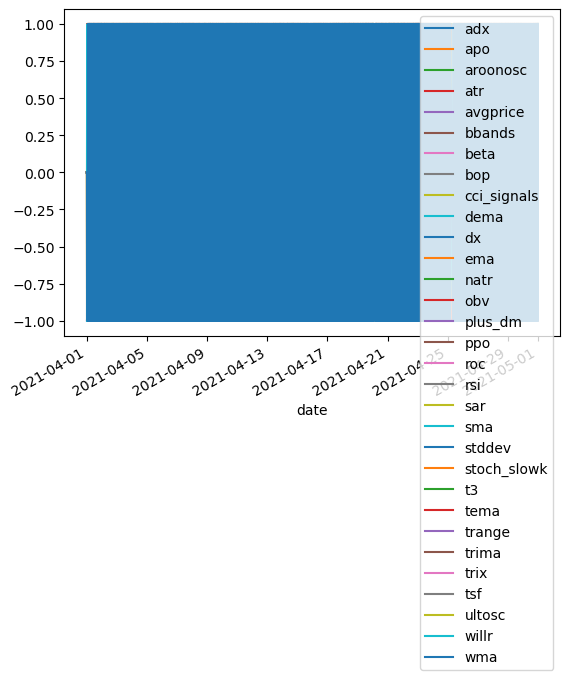

In [32]:
Optimizable_indicater(data,dic).plot()

In [29]:
print(dic['cci_signals'])
signal=pd.DataFrame(index=data.index)
cci_signals_value,cci_signals_sign=best_parameter(dic['cci_signals'])
cci = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=int(cci_signals_value[0]))
signal['pos']=np.where(cci > int(cci_signals_value[1]), (cci_signals_sign)*1, np.where(cci< -int(cci_signals_value[1]),(cci_signals_sign)* -1, 0))
signal

{'max': 30_100    0.133875
Name: total_return, dtype: float64, 'min': 2_0   -0.635902
Name: total_return, dtype: float64}


,pos
date,
2021-04-01 00:00:00,0.0
2021-04-01 00:05:00,-1.0
2021-04-01 00:10:00,-1.0
2021-04-01 00:15:00,1.0
2021-04-01 00:20:00,1.0
...,...
2021-04-30 23:40:00,-1.0
2021-04-30 23:45:00,-1.0
2021-04-30 23:50:00,-1.0


In [87]:
best_parameter(dic['cci_signals'])

(['2', '0'], -1.0)

In [88]:
dic['cci_signals']

{'max': 14_100    0.204361
 Name: total_return, dtype: float64,
 'min': 2_0   -0.631613
 Name: total_return, dtype: float64}

,pos
date,
2021-03-01 00:00:00,0.0
2021-03-01 00:05:00,1.0
2021-03-01 00:10:00,-1.0
2021-03-01 00:15:00,-1.0
2021-03-01 00:20:00,-1.0
...,...
2021-03-31 23:40:00,1.0
2021-03-31 23:45:00,-1.0
2021-03-31 23:50:00,1.0


In [10]:
last_time=time.time()
class Strategy(bt.Strategy):
    def init(self):
        self.dic={}
        self.signal=pd.DataFrame()
        self.count=1
        self.day=0
        self.vote=15
        return
    def next(self):
        data_1m=self.data.df.iloc[-29000:]
        if ((data_1m.index[-1].minute)==0):
            self.data_5m=(data_1m.resample("60T",closed='right').agg({"Open":'first',"High":'max',"Low":'min','Close':'last',"Volume":'sum'})).dropna()
            self.data_5m.index=self.data_5m.index+timedelta(hours=1)
            print(f'count:{self.count}_{data_1m.index[-1]}_{self.data_5m.index[-1]}')
            
            if (len(self.data_5m)==479):
                for i in optimization_list.keys():
                    self.dic[i]=(optimization_list[i](data_1m.copy(),self.data_5m.copy()))
#                 print("initial dic set completed")
            if (len(self.data_5m)>479):
#                 print("signals mean",abs(signals).mean())
                
                sig=pd.concat([Candelstick_indicater(self.data_5m),Optimizable_indicater(data=self.data_5m,dic=self.dic)],axis=1).sum(axis=1)
                data_1m["pos"]=0
                idx=data_1m.loc[data_1m.index.isin(self.data_5m.index)].index
                data_1m.loc[idx,"pos"]=sig.loc[idx]
                price=data_1m.Close[-1]
                pos=data_1m.pos[-1]
                current_day=data_1m.index[-1].day
                print("pos",pos)
#                 if (current_day!=self.day):
                if ((pos>self.vote) | (pos<-self.vote)) & ((self.position.is_short==True) | (self.position.is_long==True)):
                    self.position.close()

                    print(f'{data_1m.index[-1]}_vote:{pos}_current:{current_day}_last_day:{self.day}_squareoff')

                if (pos>self.vote) & (self.position.is_short==False) & (self.position.is_long==False):
                    self.buy(sl=0.95*price,tp=1.051*price)
                    print(f'{data_1m.index[-1]}_vote:{pos}_current:{current_day}_last_day:{self.day}_long')
                    self.day=current_day
                elif (pos<-self.vote)&(self.position.is_long==False) & (self.position.is_short==False):
                    self.sell(sl=1.05*price,tp=0.949*price)
                    print(f'{data_1m.index[-1]}_vote:{pos}_current:{current_day}_last_day:{self.day}_short')
                    self.day=current_day
                if (data_1m.index[-1].hour==23) &(current_day%4==0) :
                    for i in optimization_list.keys():
                        self.dic[i]=(optimization_list[i](data_1m.copy(),self.data_5m.copy()))
    #                     print("dic updated at end of the day")
        self.count+=1
        return
pf=bt.Backtest(data_1m,Strategy,trade_on_close=True,cash=9999999999999999999999999999)
pf_data=pf.run()
print(pf_data) #3
print(time.time()-last_time)

count:60_2023-01-01 01:00:00_2023-01-01 01:00:00
count:120_2023-01-01 02:00:00_2023-01-01 02:00:00
count:180_2023-01-01 03:00:00_2023-01-01 03:00:00
count:240_2023-01-01 04:00:00_2023-01-01 04:00:00
count:300_2023-01-01 05:00:00_2023-01-01 05:00:00
count:360_2023-01-01 06:00:00_2023-01-01 06:00:00
count:420_2023-01-01 07:00:00_2023-01-01 07:00:00
count:480_2023-01-01 08:00:00_2023-01-01 08:00:00
count:540_2023-01-01 09:00:00_2023-01-01 09:00:00
count:600_2023-01-01 10:00:00_2023-01-01 10:00:00
count:660_2023-01-01 11:00:00_2023-01-01 11:00:00
count:720_2023-01-01 12:00:00_2023-01-01 12:00:00
count:780_2023-01-01 13:00:00_2023-01-01 13:00:00
count:840_2023-01-01 14:00:00_2023-01-01 14:00:00
count:900_2023-01-01 15:00:00_2023-01-01 15:00:00
count:960_2023-01-01 16:00:00_2023-01-01 16:00:00
count:1020_2023-01-01 17:00:00_2023-01-01 17:00:00
count:1080_2023-01-01 18:00:00_2023-01-01 18:00:00
count:1140_2023-01-01 19:00:00_2023-01-01 19:00:00
count:1200_2023-01-01 20:00:00_2023-01-01 20:00:

count:10080_2023-01-08 00:00:00_2023-01-08 00:00:00
count:10140_2023-01-08 01:00:00_2023-01-08 01:00:00
count:10200_2023-01-08 02:00:00_2023-01-08 02:00:00
count:10260_2023-01-08 03:00:00_2023-01-08 03:00:00
count:10320_2023-01-08 04:00:00_2023-01-08 04:00:00
count:10380_2023-01-08 05:00:00_2023-01-08 05:00:00
count:10440_2023-01-08 06:00:00_2023-01-08 06:00:00
count:10500_2023-01-08 07:00:00_2023-01-08 07:00:00
count:10560_2023-01-08 08:00:00_2023-01-08 08:00:00
count:10620_2023-01-08 09:00:00_2023-01-08 09:00:00
count:10680_2023-01-08 10:00:00_2023-01-08 10:00:00
count:10740_2023-01-08 11:00:00_2023-01-08 11:00:00
count:10800_2023-01-08 12:00:00_2023-01-08 12:00:00
count:10860_2023-01-08 13:00:00_2023-01-08 13:00:00
count:10920_2023-01-08 14:00:00_2023-01-08 14:00:00
count:10980_2023-01-08 15:00:00_2023-01-08 15:00:00
count:11040_2023-01-08 16:00:00_2023-01-08 16:00:00
count:11100_2023-01-08 17:00:00_2023-01-08 17:00:00
count:11160_2023-01-08 18:00:00_2023-01-08 18:00:00
count:11220_

count:19980_2023-01-14 21:00:00_2023-01-14 21:00:00
count:20040_2023-01-14 22:00:00_2023-01-14 22:00:00
count:20100_2023-01-14 23:00:00_2023-01-14 23:00:00
count:20160_2023-01-15 00:00:00_2023-01-15 00:00:00
count:20220_2023-01-15 01:00:00_2023-01-15 01:00:00
count:20280_2023-01-15 02:00:00_2023-01-15 02:00:00
count:20340_2023-01-15 03:00:00_2023-01-15 03:00:00
count:20400_2023-01-15 04:00:00_2023-01-15 04:00:00
count:20460_2023-01-15 05:00:00_2023-01-15 05:00:00
count:20520_2023-01-15 06:00:00_2023-01-15 06:00:00
count:20580_2023-01-15 07:00:00_2023-01-15 07:00:00
count:20640_2023-01-15 08:00:00_2023-01-15 08:00:00
count:20700_2023-01-15 09:00:00_2023-01-15 09:00:00
count:20760_2023-01-15 10:00:00_2023-01-15 10:00:00
count:20820_2023-01-15 11:00:00_2023-01-15 11:00:00
count:20880_2023-01-15 12:00:00_2023-01-15 12:00:00
count:20940_2023-01-15 13:00:00_2023-01-15 13:00:00
count:21000_2023-01-15 14:00:00_2023-01-15 14:00:00
count:21060_2023-01-15 15:00:00_2023-01-15 15:00:00
count:21120_

pos 13
count:29280_2023-01-21 08:00:00_2023-01-21 08:00:00
pos 11
count:29340_2023-01-21 09:00:00_2023-01-21 09:00:00
pos 10
count:29400_2023-01-21 10:00:00_2023-01-21 10:00:00
pos 19
2023-01-21 10:00:00_vote:19_current:21_last_day:20_long
count:29460_2023-01-21 11:00:00_2023-01-21 11:00:00
pos 13
count:29520_2023-01-21 12:00:00_2023-01-21 12:00:00
pos 21
2023-01-21 12:00:00_vote:21_current:21_last_day:21_squareoff
count:29580_2023-01-21 13:00:00_2023-01-21 13:00:00
pos 20
2023-01-21 13:00:00_vote:20_current:21_last_day:21_long
count:29640_2023-01-21 14:00:00_2023-01-21 14:00:00
pos 9
count:29700_2023-01-21 15:00:00_2023-01-21 15:00:00
pos 12
count:29760_2023-01-21 16:00:00_2023-01-21 16:00:00
pos 15
count:29820_2023-01-21 17:00:00_2023-01-21 17:00:00
pos 22
2023-01-21 17:00:00_vote:22_current:21_last_day:21_squareoff
count:29880_2023-01-21 18:00:00_2023-01-21 18:00:00
pos 18
2023-01-21 18:00:00_vote:18_current:21_last_day:21_long
count:29940_2023-01-21 19:00:00_2023-01-21 19:00:00
pos

pos 2
count:37020_2023-01-26 17:00:00_2023-01-26 17:00:00
pos 4
count:37080_2023-01-26 18:00:00_2023-01-26 18:00:00
pos -6
count:37140_2023-01-26 19:00:00_2023-01-26 19:00:00
pos 4
count:37200_2023-01-26 20:00:00_2023-01-26 20:00:00
pos 6
count:37260_2023-01-26 21:00:00_2023-01-26 21:00:00
pos 7
count:37320_2023-01-26 22:00:00_2023-01-26 22:00:00
pos 5
count:37380_2023-01-26 23:00:00_2023-01-26 23:00:00
pos -6
count:37440_2023-01-27 00:00:00_2023-01-27 00:00:00
pos -3
count:37500_2023-01-27 01:00:00_2023-01-27 01:00:00
pos -9
count:37560_2023-01-27 02:00:00_2023-01-27 02:00:00
pos -8
count:37620_2023-01-27 03:00:00_2023-01-27 03:00:00
pos -3
count:37680_2023-01-27 04:00:00_2023-01-27 04:00:00
pos -15
count:37740_2023-01-27 05:00:00_2023-01-27 05:00:00
pos -9
count:37800_2023-01-27 06:00:00_2023-01-27 06:00:00
pos 11
count:37860_2023-01-27 07:00:00_2023-01-27 07:00:00
pos 0
count:37920_2023-01-27 08:00:00_2023-01-27 08:00:00
pos 6
count:37980_2023-01-27 09:00:00_2023-01-27 09:00:00
pos 

pos 4
count:44700_2023-02-01 01:00:00_2023-02-01 01:00:00
pos 7
count:44760_2023-02-01 02:00:00_2023-02-01 02:00:00
pos 10
count:44820_2023-02-01 03:00:00_2023-02-01 03:00:00
pos -2
count:44880_2023-02-01 04:00:00_2023-02-01 04:00:00
pos 6
count:44940_2023-02-01 05:00:00_2023-02-01 05:00:00
pos 0
count:45000_2023-02-01 06:00:00_2023-02-01 06:00:00
pos -6
count:45060_2023-02-01 07:00:00_2023-02-01 07:00:00
pos -4
count:45120_2023-02-01 08:00:00_2023-02-01 08:00:00
pos -1
count:45180_2023-02-01 09:00:00_2023-02-01 09:00:00
pos -6
count:45240_2023-02-01 10:00:00_2023-02-01 10:00:00
pos 1
count:45300_2023-02-01 11:00:00_2023-02-01 11:00:00
pos -10
count:45360_2023-02-01 12:00:00_2023-02-01 12:00:00
pos -1
count:45420_2023-02-01 13:00:00_2023-02-01 13:00:00
pos -10
count:45480_2023-02-01 14:00:00_2023-02-01 14:00:00
pos 3
count:45540_2023-02-01 15:00:00_2023-02-01 15:00:00
pos -1
count:45600_2023-02-01 16:00:00_2023-02-01 16:00:00
pos -4
count:45660_2023-02-01 17:00:00_2023-02-01 17:00:00
p

pos 1
count:52500_2023-02-06 11:00:00_2023-02-06 11:00:00
pos 1
count:52560_2023-02-06 12:00:00_2023-02-06 12:00:00
pos 5
count:52620_2023-02-06 13:00:00_2023-02-06 13:00:00
pos -5
count:52680_2023-02-06 14:00:00_2023-02-06 14:00:00
pos 1
count:52740_2023-02-06 15:00:00_2023-02-06 15:00:00
pos 3
count:52800_2023-02-06 16:00:00_2023-02-06 16:00:00
pos 9
count:52860_2023-02-06 17:00:00_2023-02-06 17:00:00
pos 2
count:52920_2023-02-06 18:00:00_2023-02-06 18:00:00
pos 0
count:52980_2023-02-06 19:00:00_2023-02-06 19:00:00
pos -5
count:53040_2023-02-06 20:00:00_2023-02-06 20:00:00
pos -6
count:53100_2023-02-06 21:00:00_2023-02-06 21:00:00
pos -4
count:53160_2023-02-06 22:00:00_2023-02-06 22:00:00
pos -1
count:53220_2023-02-06 23:00:00_2023-02-06 23:00:00
pos -2
count:53280_2023-02-07 00:00:00_2023-02-07 00:00:00
pos 12
count:53340_2023-02-07 01:00:00_2023-02-07 01:00:00
pos 5
count:53400_2023-02-07 02:00:00_2023-02-07 02:00:00
pos 5
count:53460_2023-02-07 03:00:00_2023-02-07 03:00:00
pos 3
c

pos -1
count:60960_2023-02-12 08:00:00_2023-02-12 08:00:00
pos 0
count:61020_2023-02-12 09:00:00_2023-02-12 09:00:00
pos -10
count:61080_2023-02-12 10:00:00_2023-02-12 10:00:00
pos -7
count:61140_2023-02-12 11:00:00_2023-02-12 11:00:00
pos 2
count:61200_2023-02-12 12:00:00_2023-02-12 12:00:00
pos -5
count:61260_2023-02-12 13:00:00_2023-02-12 13:00:00
pos 0
count:61320_2023-02-12 14:00:00_2023-02-12 14:00:00
pos -5
count:61380_2023-02-12 15:00:00_2023-02-12 15:00:00
pos -2
count:61440_2023-02-12 16:00:00_2023-02-12 16:00:00
pos 3
count:61500_2023-02-12 17:00:00_2023-02-12 17:00:00
pos 2
count:61560_2023-02-12 18:00:00_2023-02-12 18:00:00
pos 3
count:61620_2023-02-12 19:00:00_2023-02-12 19:00:00
pos -12
count:61680_2023-02-12 20:00:00_2023-02-12 20:00:00
pos 0
count:61740_2023-02-12 21:00:00_2023-02-12 21:00:00
pos 1
count:61800_2023-02-12 22:00:00_2023-02-12 22:00:00
pos 8
count:61860_2023-02-12 23:00:00_2023-02-12 23:00:00
pos 2
count:61920_2023-02-13 00:00:00_2023-02-13 00:00:00
pos 0

pos 17
2023-02-17 20:00:00_vote:17_current:17_last_day:17_long
count:68940_2023-02-17 21:00:00_2023-02-17 21:00:00
pos 22
2023-02-17 21:00:00_vote:22_current:17_last_day:17_squareoff
count:69000_2023-02-17 22:00:00_2023-02-17 22:00:00
pos 6
count:69060_2023-02-17 23:00:00_2023-02-17 23:00:00
pos 14
count:69120_2023-02-18 00:00:00_2023-02-18 00:00:00
pos 4
count:69180_2023-02-18 01:00:00_2023-02-18 01:00:00
pos 13
count:69240_2023-02-18 02:00:00_2023-02-18 02:00:00
pos 7
count:69300_2023-02-18 03:00:00_2023-02-18 03:00:00
pos -1
count:69360_2023-02-18 04:00:00_2023-02-18 04:00:00
pos 5
count:69420_2023-02-18 05:00:00_2023-02-18 05:00:00
pos -1
count:69480_2023-02-18 06:00:00_2023-02-18 06:00:00
pos 4
count:69540_2023-02-18 07:00:00_2023-02-18 07:00:00
pos -9
count:69600_2023-02-18 08:00:00_2023-02-18 08:00:00
pos -4
count:69660_2023-02-18 09:00:00_2023-02-18 09:00:00
pos 9
count:69720_2023-02-18 10:00:00_2023-02-18 10:00:00
pos -6
count:69780_2023-02-18 11:00:00_2023-02-18 11:00:00
pos 

pos 8
count:76920_2023-02-23 10:00:00_2023-02-23 10:00:00
pos -7
count:76980_2023-02-23 11:00:00_2023-02-23 11:00:00
pos -4
count:77040_2023-02-23 12:00:00_2023-02-23 12:00:00
pos -7
count:77100_2023-02-23 13:00:00_2023-02-23 13:00:00
pos 9
count:77160_2023-02-23 14:00:00_2023-02-23 14:00:00
pos 3
count:77220_2023-02-23 15:00:00_2023-02-23 15:00:00
pos -4
count:77280_2023-02-23 16:00:00_2023-02-23 16:00:00
pos -7
count:77340_2023-02-23 17:00:00_2023-02-23 17:00:00
pos -10
count:77400_2023-02-23 18:00:00_2023-02-23 18:00:00
pos 0
count:77460_2023-02-23 19:00:00_2023-02-23 19:00:00
pos -12
count:77520_2023-02-23 20:00:00_2023-02-23 20:00:00
pos 3
count:77580_2023-02-23 21:00:00_2023-02-23 21:00:00
pos -16
2023-02-23 21:00:00_vote:-16_current:23_last_day:23_squareoff
count:77640_2023-02-23 22:00:00_2023-02-23 22:00:00
pos -14
count:77700_2023-02-23 23:00:00_2023-02-23 23:00:00
pos -20
2023-02-23 23:00:00_vote:-20_current:23_last_day:23_short
count:77760_2023-02-24 00:00:00_2023-02-24 00:0

pos -13
count:84900_2023-02-28 23:00:00_2023-02-28 23:00:00
pos -6
count:84960_2023-03-01 00:00:00_2023-03-01 00:00:00
pos -10
count:85020_2023-03-01 01:00:00_2023-03-01 01:00:00
pos -17
2023-03-01 01:00:00_vote:-17_current:1_last_day:26_short
count:85080_2023-03-01 02:00:00_2023-03-01 02:00:00
pos 1
count:85140_2023-03-01 03:00:00_2023-03-01 03:00:00
pos 4
count:85200_2023-03-01 04:00:00_2023-03-01 04:00:00
pos 8
count:85260_2023-03-01 05:00:00_2023-03-01 05:00:00
pos 19
2023-03-01 05:00:00_vote:19_current:1_last_day:1_squareoff
count:85320_2023-03-01 06:00:00_2023-03-01 06:00:00
pos 10
count:85380_2023-03-01 07:00:00_2023-03-01 07:00:00
pos 18
2023-03-01 07:00:00_vote:18_current:1_last_day:1_long
count:85440_2023-03-01 08:00:00_2023-03-01 08:00:00
pos 4
count:85500_2023-03-01 09:00:00_2023-03-01 09:00:00
pos 21
2023-03-01 09:00:00_vote:21_current:1_last_day:1_squareoff
count:85560_2023-03-01 10:00:00_2023-03-01 10:00:00
pos 7
count:85620_2023-03-01 11:00:00_2023-03-01 11:00:00
pos 9


pos 0
count:92640_2023-03-06 08:00:00_2023-03-06 08:00:00
pos -12
count:92700_2023-03-06 09:00:00_2023-03-06 09:00:00
pos -6
count:92760_2023-03-06 10:00:00_2023-03-06 10:00:00
pos -6
count:92820_2023-03-06 11:00:00_2023-03-06 11:00:00
pos -3
count:92880_2023-03-06 12:00:00_2023-03-06 12:00:00
pos -14
count:92940_2023-03-06 13:00:00_2023-03-06 13:00:00
pos 2
count:93000_2023-03-06 14:00:00_2023-03-06 14:00:00
pos 8
count:93060_2023-03-06 15:00:00_2023-03-06 15:00:00
pos -5
count:93120_2023-03-06 16:00:00_2023-03-06 16:00:00
pos 10
count:93180_2023-03-06 17:00:00_2023-03-06 17:00:00
pos 5
count:93240_2023-03-06 18:00:00_2023-03-06 18:00:00
pos -1
count:93300_2023-03-06 19:00:00_2023-03-06 19:00:00
pos 5
count:93360_2023-03-06 20:00:00_2023-03-06 20:00:00
pos -12
count:93420_2023-03-06 21:00:00_2023-03-06 21:00:00
pos -12
count:93480_2023-03-06 22:00:00_2023-03-06 22:00:00
pos -7
count:93540_2023-03-06 23:00:00_2023-03-06 23:00:00
pos -6
count:93600_2023-03-07 00:00:00_2023-03-07 00:00:0

pos 4
count:100080_2023-03-11 12:00:00_2023-03-11 12:00:00
pos 0
count:100140_2023-03-11 13:00:00_2023-03-11 13:00:00
pos 4
count:100200_2023-03-11 14:00:00_2023-03-11 14:00:00
pos 2
count:100260_2023-03-11 15:00:00_2023-03-11 15:00:00
pos -5
count:100320_2023-03-11 16:00:00_2023-03-11 16:00:00
pos 1
count:100380_2023-03-11 17:00:00_2023-03-11 17:00:00
pos -8
count:100440_2023-03-11 18:00:00_2023-03-11 18:00:00
pos -12
count:100500_2023-03-11 19:00:00_2023-03-11 19:00:00
pos -11
count:100560_2023-03-11 20:00:00_2023-03-11 20:00:00
pos -22
2023-03-11 20:00:00_vote:-22_current:11_last_day:11_squareoff
count:100620_2023-03-11 21:00:00_2023-03-11 21:00:00
pos -16
2023-03-11 21:00:00_vote:-16_current:11_last_day:11_short
count:100680_2023-03-11 22:00:00_2023-03-11 22:00:00
pos -22
2023-03-11 22:00:00_vote:-22_current:11_last_day:11_squareoff
count:100740_2023-03-11 23:00:00_2023-03-11 23:00:00
pos -17
2023-03-11 23:00:00_vote:-17_current:11_last_day:11_short
count:100800_2023-03-12 00:00:00

pos -9
count:107400_2023-03-16 14:00:00_2023-03-16 14:00:00
pos 5
count:107460_2023-03-16 15:00:00_2023-03-16 15:00:00
pos 2
count:107520_2023-03-16 16:00:00_2023-03-16 16:00:00
pos 0
count:107580_2023-03-16 17:00:00_2023-03-16 17:00:00
pos -9
count:107640_2023-03-16 18:00:00_2023-03-16 18:00:00
pos -12
count:107700_2023-03-16 19:00:00_2023-03-16 19:00:00
pos 0
count:107760_2023-03-16 20:00:00_2023-03-16 20:00:00
pos 4
count:107820_2023-03-16 21:00:00_2023-03-16 21:00:00
pos -7
count:107880_2023-03-16 22:00:00_2023-03-16 22:00:00
pos 7
count:107940_2023-03-16 23:00:00_2023-03-16 23:00:00
pos 3
count:108000_2023-03-17 00:00:00_2023-03-17 00:00:00
pos 3
count:108060_2023-03-17 01:00:00_2023-03-17 01:00:00
pos -2
count:108120_2023-03-17 02:00:00_2023-03-17 02:00:00
pos 24
2023-03-17 02:00:00_vote:24_current:17_last_day:15_long
count:108180_2023-03-17 03:00:00_2023-03-17 03:00:00
pos 15
count:108240_2023-03-17 04:00:00_2023-03-17 04:00:00
pos 18
2023-03-17 04:00:00_vote:18_current:17_last_

pos 6
count:114780_2023-03-21 17:00:00_2023-03-21 17:00:00
pos 22
2023-03-21 17:00:00_vote:22_current:21_last_day:21_long
count:114840_2023-03-21 18:00:00_2023-03-21 18:00:00
pos 1
count:114900_2023-03-21 19:00:00_2023-03-21 19:00:00
pos 6
count:114960_2023-03-21 20:00:00_2023-03-21 20:00:00
pos 1
count:115020_2023-03-21 21:00:00_2023-03-21 21:00:00
pos 3
count:115080_2023-03-21 22:00:00_2023-03-21 22:00:00
pos 4
count:115140_2023-03-21 23:00:00_2023-03-21 23:00:00
pos -2
count:115200_2023-03-22 00:00:00_2023-03-22 00:00:00
pos 11
count:115260_2023-03-22 01:00:00_2023-03-22 01:00:00
pos -2
count:115320_2023-03-22 02:00:00_2023-03-22 02:00:00
pos 8
count:115380_2023-03-22 03:00:00_2023-03-22 03:00:00
pos 5
count:115440_2023-03-22 04:00:00_2023-03-22 04:00:00
pos 17
2023-03-22 04:00:00_vote:17_current:22_last_day:21_squareoff
count:115500_2023-03-22 05:00:00_2023-03-22 05:00:00
pos 11
count:115560_2023-03-22 06:00:00_2023-03-22 06:00:00
pos 6
count:115620_2023-03-22 07:00:00_2023-03-22 0

pos 13
count:122260_2023-03-26 23:00:00_2023-03-26 23:00:00
pos 11
count:122320_2023-03-27 00:00:00_2023-03-27 00:00:00
pos 7
count:122380_2023-03-27 01:00:00_2023-03-27 01:00:00
pos 11
count:122440_2023-03-27 02:00:00_2023-03-27 02:00:00
pos 3
count:122500_2023-03-27 03:00:00_2023-03-27 03:00:00
pos 13
count:122560_2023-03-27 04:00:00_2023-03-27 04:00:00
pos 5
count:122620_2023-03-27 05:00:00_2023-03-27 05:00:00
pos 4
count:122680_2023-03-27 06:00:00_2023-03-27 06:00:00
pos -1
count:122740_2023-03-27 07:00:00_2023-03-27 07:00:00
pos 5
count:122800_2023-03-27 08:00:00_2023-03-27 08:00:00
pos 5
count:122860_2023-03-27 09:00:00_2023-03-27 09:00:00
pos 13
count:122920_2023-03-27 10:00:00_2023-03-27 10:00:00
pos 14
count:122980_2023-03-27 11:00:00_2023-03-27 11:00:00
pos 1
count:123040_2023-03-27 12:00:00_2023-03-27 12:00:00
pos 0
count:123100_2023-03-27 13:00:00_2023-03-27 13:00:00
pos -7
count:123160_2023-03-27 14:00:00_2023-03-27 14:00:00
pos -9
count:123220_2023-03-27 15:00:00_2023-03-

count:129700_2023-04-01 03:00:00_2023-04-01 03:00:00
pos 6
count:129760_2023-04-01 04:00:00_2023-04-01 04:00:00
pos 4
count:129820_2023-04-01 05:00:00_2023-04-01 05:00:00
pos 14
count:129880_2023-04-01 06:00:00_2023-04-01 06:00:00
pos 4
count:129940_2023-04-01 07:00:00_2023-04-01 07:00:00
pos 6
count:130000_2023-04-01 08:00:00_2023-04-01 08:00:00
pos 1
count:130060_2023-04-01 09:00:00_2023-04-01 09:00:00
pos 7
count:130120_2023-04-01 10:00:00_2023-04-01 10:00:00
pos -3
count:130180_2023-04-01 11:00:00_2023-04-01 11:00:00
pos 14
count:130240_2023-04-01 12:00:00_2023-04-01 12:00:00
pos -3
count:130300_2023-04-01 13:00:00_2023-04-01 13:00:00
pos 12
count:130360_2023-04-01 14:00:00_2023-04-01 14:00:00
pos -2
count:130420_2023-04-01 15:00:00_2023-04-01 15:00:00
pos -8
count:130480_2023-04-01 16:00:00_2023-04-01 16:00:00
pos 7
count:130540_2023-04-01 17:00:00_2023-04-01 17:00:00
pos -9
count:130600_2023-04-01 18:00:00_2023-04-01 18:00:00
pos 4
count:130660_2023-04-01 19:00:00_2023-04-01 19:0

pos 15
count:137380_2023-04-06 11:00:00_2023-04-06 11:00:00
pos 15
count:137440_2023-04-06 12:00:00_2023-04-06 12:00:00
pos 0
count:137500_2023-04-06 13:00:00_2023-04-06 13:00:00
pos 3
count:137560_2023-04-06 14:00:00_2023-04-06 14:00:00
pos 5
count:137620_2023-04-06 15:00:00_2023-04-06 15:00:00
pos -3
count:137680_2023-04-06 16:00:00_2023-04-06 16:00:00
pos -13
count:137740_2023-04-06 17:00:00_2023-04-06 17:00:00
pos 0
count:137800_2023-04-06 18:00:00_2023-04-06 18:00:00
pos 6
count:137860_2023-04-06 19:00:00_2023-04-06 19:00:00
pos 11
count:137920_2023-04-06 20:00:00_2023-04-06 20:00:00
pos 8
count:137980_2023-04-06 21:00:00_2023-04-06 21:00:00
pos 8
count:138040_2023-04-06 22:00:00_2023-04-06 22:00:00
pos 5
count:138100_2023-04-06 23:00:00_2023-04-06 23:00:00
pos 3
count:138160_2023-04-07 00:00:00_2023-04-07 00:00:00
pos 2
count:138220_2023-04-07 01:00:00_2023-04-07 01:00:00
pos -6
count:138280_2023-04-07 02:00:00_2023-04-07 02:00:00
pos 1
count:138340_2023-04-07 03:00:00_2023-04-07

pos -8
count:144940_2023-04-11 17:00:00_2023-04-11 17:00:00
pos 7
count:145000_2023-04-11 18:00:00_2023-04-11 18:00:00
pos -3
count:145060_2023-04-11 19:00:00_2023-04-11 19:00:00
pos -3
count:145120_2023-04-11 20:00:00_2023-04-11 20:00:00
pos 1
count:145180_2023-04-11 21:00:00_2023-04-11 21:00:00
pos -5
count:145240_2023-04-11 22:00:00_2023-04-11 22:00:00
pos -13
count:145300_2023-04-11 23:00:00_2023-04-11 23:00:00
pos -10
count:145360_2023-04-12 00:00:00_2023-04-12 00:00:00
pos -2
count:145420_2023-04-12 01:00:00_2023-04-12 01:00:00
pos -5
count:145480_2023-04-12 02:00:00_2023-04-12 02:00:00
pos 13
count:145540_2023-04-12 03:00:00_2023-04-12 03:00:00
pos 13
count:145600_2023-04-12 04:00:00_2023-04-12 04:00:00
pos 8
count:145660_2023-04-12 05:00:00_2023-04-12 05:00:00
pos 4
count:145720_2023-04-12 06:00:00_2023-04-12 06:00:00
pos 14
count:145780_2023-04-12 07:00:00_2023-04-12 07:00:00
pos 7
count:145840_2023-04-12 08:00:00_2023-04-12 08:00:00
pos -1
count:145900_2023-04-12 09:00:00_202

count:152440_2023-04-16 22:00:00_2023-04-16 22:00:00
pos -5
count:152500_2023-04-16 23:00:00_2023-04-16 23:00:00
pos 8
count:152560_2023-04-17 00:00:00_2023-04-17 00:00:00
pos 15
count:152620_2023-04-17 01:00:00_2023-04-17 01:00:00
pos 27
2023-04-17 01:00:00_vote:27_current:17_last_day:15_squareoff
count:152680_2023-04-17 02:00:00_2023-04-17 02:00:00
pos 12
count:152740_2023-04-17 03:00:00_2023-04-17 03:00:00
pos 5
count:152800_2023-04-17 04:00:00_2023-04-17 04:00:00
pos 10
count:152860_2023-04-17 05:00:00_2023-04-17 05:00:00
pos -2
count:152920_2023-04-17 06:00:00_2023-04-17 06:00:00
pos -5
count:152980_2023-04-17 07:00:00_2023-04-17 07:00:00
pos 19
2023-04-17 07:00:00_vote:19_current:17_last_day:15_long
count:153040_2023-04-17 08:00:00_2023-04-17 08:00:00
pos 19
2023-04-17 08:00:00_vote:19_current:17_last_day:17_squareoff
count:153100_2023-04-17 09:00:00_2023-04-17 09:00:00
pos 4
count:153160_2023-04-17 10:00:00_2023-04-17 10:00:00
pos 12
count:153220_2023-04-17 11:00:00_2023-04-17 1

pos -15
count:159100_2023-04-21 13:00:00_2023-04-21 13:00:00
pos -5
count:159160_2023-04-21 14:00:00_2023-04-21 14:00:00
pos -4
count:159220_2023-04-21 15:00:00_2023-04-21 15:00:00
pos 1
count:159280_2023-04-21 16:00:00_2023-04-21 16:00:00
pos -4
count:159340_2023-04-21 17:00:00_2023-04-21 17:00:00
pos -12
count:159400_2023-04-21 18:00:00_2023-04-21 18:00:00
pos -5
count:159460_2023-04-21 19:00:00_2023-04-21 19:00:00
pos -4
count:159520_2023-04-21 20:00:00_2023-04-21 20:00:00
pos 1
count:159580_2023-04-21 21:00:00_2023-04-21 21:00:00
pos -14
count:159640_2023-04-21 22:00:00_2023-04-21 22:00:00
pos -7
count:159700_2023-04-21 23:00:00_2023-04-21 23:00:00
pos -8
count:159760_2023-04-22 00:00:00_2023-04-22 00:00:00
pos -13
count:159820_2023-04-22 01:00:00_2023-04-22 01:00:00
pos -10
count:159880_2023-04-22 02:00:00_2023-04-22 02:00:00
pos -11
count:159940_2023-04-22 03:00:00_2023-04-22 03:00:00
pos -8
count:160000_2023-04-22 04:00:00_2023-04-22 04:00:00
pos -12
count:160060_2023-04-22 05:0

pos -2
count:167080_2023-04-27 02:00:00_2023-04-27 02:00:00
pos -6
count:167140_2023-04-27 03:00:00_2023-04-27 03:00:00
pos -4
count:167200_2023-04-27 04:00:00_2023-04-27 04:00:00
pos -3
count:167260_2023-04-27 05:00:00_2023-04-27 05:00:00
pos -6
count:167320_2023-04-27 06:00:00_2023-04-27 06:00:00
pos 7
count:167380_2023-04-27 07:00:00_2023-04-27 07:00:00
pos -3
count:167440_2023-04-27 08:00:00_2023-04-27 08:00:00
pos -11
count:167500_2023-04-27 09:00:00_2023-04-27 09:00:00
pos 0
count:167560_2023-04-27 10:00:00_2023-04-27 10:00:00
pos -1
count:167620_2023-04-27 11:00:00_2023-04-27 11:00:00
pos -2
count:167680_2023-04-27 12:00:00_2023-04-27 12:00:00
pos -6
count:167740_2023-04-27 13:00:00_2023-04-27 13:00:00
pos -6
count:167800_2023-04-27 14:00:00_2023-04-27 14:00:00
pos 2
count:167860_2023-04-27 15:00:00_2023-04-27 15:00:00
pos 1
count:167920_2023-04-27 16:00:00_2023-04-27 16:00:00
pos 9
count:167980_2023-04-27 17:00:00_2023-04-27 17:00:00
pos 10
count:168040_2023-04-27 18:00:00_2023

pos 6
count:175420_2023-05-02 21:00:00_2023-05-02 21:00:00
pos 5
count:175480_2023-05-02 22:00:00_2023-05-02 22:00:00
pos -5
count:175540_2023-05-02 23:00:00_2023-05-02 23:00:00
pos 0
count:175600_2023-05-03 00:00:00_2023-05-03 00:00:00
pos 4
count:175660_2023-05-03 01:00:00_2023-05-03 01:00:00
pos 5
count:175720_2023-05-03 02:00:00_2023-05-03 02:00:00
pos -2
count:175780_2023-05-03 03:00:00_2023-05-03 03:00:00
pos -1
count:175840_2023-05-03 04:00:00_2023-05-03 04:00:00
pos -10
count:175900_2023-05-03 05:00:00_2023-05-03 05:00:00
pos -7
count:175960_2023-05-03 06:00:00_2023-05-03 06:00:00
pos 0
count:176020_2023-05-03 07:00:00_2023-05-03 07:00:00
pos 1
count:176080_2023-05-03 08:00:00_2023-05-03 08:00:00
pos 0
count:176140_2023-05-03 09:00:00_2023-05-03 09:00:00
pos 2
count:176200_2023-05-03 10:00:00_2023-05-03 10:00:00
pos 6
count:176260_2023-05-03 11:00:00_2023-05-03 11:00:00
pos -2
count:176320_2023-05-03 12:00:00_2023-05-03 12:00:00
pos -5
count:176380_2023-05-03 13:00:00_2023-05-0

pos 0
count:183700_2023-05-08 15:00:00_2023-05-08 15:00:00
pos 3
count:183760_2023-05-08 16:00:00_2023-05-08 16:00:00
pos 4
count:183820_2023-05-08 17:00:00_2023-05-08 17:00:00
pos 5
count:183880_2023-05-08 18:00:00_2023-05-08 18:00:00
pos 11
count:183940_2023-05-08 19:00:00_2023-05-08 19:00:00
pos 6
count:184000_2023-05-08 20:00:00_2023-05-08 20:00:00
pos 1
count:184060_2023-05-08 21:00:00_2023-05-08 21:00:00
pos 5
count:184120_2023-05-08 22:00:00_2023-05-08 22:00:00
pos -1
count:184180_2023-05-08 23:00:00_2023-05-08 23:00:00
pos 0
count:184240_2023-05-09 00:00:00_2023-05-09 00:00:00
pos -5
count:184300_2023-05-09 01:00:00_2023-05-09 01:00:00
pos 4
count:184360_2023-05-09 02:00:00_2023-05-09 02:00:00
pos -5
count:184420_2023-05-09 03:00:00_2023-05-09 03:00:00
pos 2
count:184480_2023-05-09 04:00:00_2023-05-09 04:00:00
pos -4
count:184540_2023-05-09 05:00:00_2023-05-09 05:00:00
pos 4
count:184600_2023-05-09 06:00:00_2023-05-09 06:00:00
pos 8
count:184660_2023-05-09 07:00:00_2023-05-09 0

pos 3
count:192100_2023-05-14 11:00:00_2023-05-14 11:00:00
pos 2
count:192160_2023-05-14 12:00:00_2023-05-14 12:00:00
pos 11
count:192220_2023-05-14 13:00:00_2023-05-14 13:00:00
pos -3
count:192280_2023-05-14 14:00:00_2023-05-14 14:00:00
pos -3
count:192340_2023-05-14 15:00:00_2023-05-14 15:00:00
pos -13
count:192400_2023-05-14 16:00:00_2023-05-14 16:00:00
pos -13
count:192460_2023-05-14 17:00:00_2023-05-14 17:00:00
pos 3
count:192520_2023-05-14 18:00:00_2023-05-14 18:00:00
pos -5
count:192580_2023-05-14 19:00:00_2023-05-14 19:00:00
pos -1
count:192640_2023-05-14 20:00:00_2023-05-14 20:00:00
pos -4
count:192700_2023-05-14 21:00:00_2023-05-14 21:00:00
pos -7
count:192760_2023-05-14 22:00:00_2023-05-14 22:00:00
pos 2
count:192820_2023-05-14 23:00:00_2023-05-14 23:00:00
pos -5
count:192880_2023-05-15 00:00:00_2023-05-15 00:00:00
pos 0
count:192940_2023-05-15 01:00:00_2023-05-15 01:00:00
pos 8
count:193000_2023-05-15 02:00:00_2023-05-15 02:00:00
pos -11
count:193060_2023-05-15 03:00:00_202

count:199780_2023-05-19 19:00:00_2023-05-19 19:00:00
pos 9
count:199840_2023-05-19 20:00:00_2023-05-19 20:00:00
pos 10
count:199900_2023-05-19 21:00:00_2023-05-19 21:00:00
pos 1
count:199960_2023-05-19 22:00:00_2023-05-19 22:00:00
pos -15
count:200020_2023-05-19 23:00:00_2023-05-19 23:00:00
pos 6
count:200080_2023-05-20 00:00:00_2023-05-20 00:00:00
pos -6
count:200140_2023-05-20 01:00:00_2023-05-20 01:00:00
pos 7
count:200200_2023-05-20 02:00:00_2023-05-20 02:00:00
pos -15
count:200260_2023-05-20 03:00:00_2023-05-20 03:00:00
pos 7
count:200320_2023-05-20 04:00:00_2023-05-20 04:00:00
pos -8
count:200380_2023-05-20 05:00:00_2023-05-20 05:00:00
pos 2
count:200440_2023-05-20 06:00:00_2023-05-20 06:00:00
pos -8
count:200500_2023-05-20 07:00:00_2023-05-20 07:00:00
pos 4
count:200560_2023-05-20 08:00:00_2023-05-20 08:00:00
pos -12
count:200620_2023-05-20 09:00:00_2023-05-20 09:00:00
pos -14
count:200680_2023-05-20 10:00:00_2023-05-20 10:00:00
pos 8
count:200740_2023-05-20 11:00:00_2023-05-20 

count:207100_2023-05-24 21:00:00_2023-05-24 21:00:00
pos -3
count:207160_2023-05-24 22:00:00_2023-05-24 22:00:00
pos 16
2023-05-24 22:00:00_vote:16_current:24_last_day:24_long
count:207220_2023-05-24 23:00:00_2023-05-24 23:00:00
pos 13
count:207280_2023-05-25 00:00:00_2023-05-25 00:00:00
pos 3
count:207340_2023-05-25 01:00:00_2023-05-25 01:00:00
pos 7
count:207400_2023-05-25 02:00:00_2023-05-25 02:00:00
pos 12
count:207460_2023-05-25 03:00:00_2023-05-25 03:00:00
pos 0
count:207520_2023-05-25 04:00:00_2023-05-25 04:00:00
pos -7
count:207580_2023-05-25 05:00:00_2023-05-25 05:00:00
pos -5
count:207640_2023-05-25 06:00:00_2023-05-25 06:00:00
pos -9
count:207700_2023-05-25 07:00:00_2023-05-25 07:00:00
pos 6
count:207760_2023-05-25 08:00:00_2023-05-25 08:00:00
pos 6
count:207820_2023-05-25 09:00:00_2023-05-25 09:00:00
pos -12
count:207880_2023-05-25 10:00:00_2023-05-25 10:00:00
pos -12
count:207940_2023-05-25 11:00:00_2023-05-25 11:00:00
pos 3
count:208000_2023-05-25 12:00:00_2023-05-25 12:0

pos -6
count:214780_2023-05-30 05:00:00_2023-05-30 05:00:00
pos 5
count:214840_2023-05-30 06:00:00_2023-05-30 06:00:00
pos -1
count:214900_2023-05-30 07:00:00_2023-05-30 07:00:00
pos -12
count:214960_2023-05-30 08:00:00_2023-05-30 08:00:00
pos 5
count:215020_2023-05-30 09:00:00_2023-05-30 09:00:00
pos -8
count:215080_2023-05-30 10:00:00_2023-05-30 10:00:00
pos -4
count:215140_2023-05-30 11:00:00_2023-05-30 11:00:00
pos 1
count:215200_2023-05-30 12:00:00_2023-05-30 12:00:00
pos -2
count:215260_2023-05-30 13:00:00_2023-05-30 13:00:00
pos 14
count:215320_2023-05-30 14:00:00_2023-05-30 14:00:00
pos 8
count:215380_2023-05-30 15:00:00_2023-05-30 15:00:00
pos 7
count:215440_2023-05-30 16:00:00_2023-05-30 16:00:00
pos -1
count:215500_2023-05-30 17:00:00_2023-05-30 17:00:00
pos -11
count:215560_2023-05-30 18:00:00_2023-05-30 18:00:00
pos -1
count:215620_2023-05-30 19:00:00_2023-05-30 19:00:00
pos -13
count:215680_2023-05-30 20:00:00_2023-05-30 20:00:00
pos -12
count:215740_2023-05-30 21:00:00_2

pos -7
count:222520_2023-06-04 14:00:00_2023-06-04 14:00:00
pos 1
count:222580_2023-06-04 15:00:00_2023-06-04 15:00:00
pos -5
count:222640_2023-06-04 16:00:00_2023-06-04 16:00:00
pos 10
count:222700_2023-06-04 17:00:00_2023-06-04 17:00:00
pos 4
count:222760_2023-06-04 18:00:00_2023-06-04 18:00:00
pos -8
count:222820_2023-06-04 19:00:00_2023-06-04 19:00:00
pos -10
count:222880_2023-06-04 20:00:00_2023-06-04 20:00:00
pos -5
count:222940_2023-06-04 21:00:00_2023-06-04 21:00:00
pos -5
count:223000_2023-06-04 22:00:00_2023-06-04 22:00:00
pos 5
count:223060_2023-06-04 23:00:00_2023-06-04 23:00:00
pos 0
count:223120_2023-06-05 00:00:00_2023-06-05 00:00:00
pos -4
count:223180_2023-06-05 01:00:00_2023-06-05 01:00:00
pos 2
count:223240_2023-06-05 02:00:00_2023-06-05 02:00:00
pos -3
count:223300_2023-06-05 03:00:00_2023-06-05 03:00:00
pos 1
count:223360_2023-06-05 04:00:00_2023-06-05 04:00:00
pos 1
count:223420_2023-06-05 05:00:00_2023-06-05 05:00:00
pos -6
count:223480_2023-06-05 06:00:00_2023-0

count:230380_2023-06-10 01:00:00_2023-06-10 01:00:00
pos -11
count:230440_2023-06-10 02:00:00_2023-06-10 02:00:00
pos -7
count:230500_2023-06-10 03:00:00_2023-06-10 03:00:00
pos -8
count:230560_2023-06-10 04:00:00_2023-06-10 04:00:00
pos -17
2023-06-10 04:00:00_vote:-17_current:10_last_day:9_short
count:230620_2023-06-10 05:00:00_2023-06-10 05:00:00
pos -13
count:230680_2023-06-10 06:00:00_2023-06-10 06:00:00
pos -12
count:230740_2023-06-10 07:00:00_2023-06-10 07:00:00
pos -18
2023-06-10 07:00:00_vote:-18_current:10_last_day:10_squareoff
count:230800_2023-06-10 08:00:00_2023-06-10 08:00:00
pos -12
count:230860_2023-06-10 09:00:00_2023-06-10 09:00:00
pos -9
count:230920_2023-06-10 10:00:00_2023-06-10 10:00:00
pos -11
count:230980_2023-06-10 11:00:00_2023-06-10 11:00:00
pos -12
count:231040_2023-06-10 12:00:00_2023-06-10 12:00:00
pos -15
count:231100_2023-06-10 13:00:00_2023-06-10 13:00:00
pos -12
count:231160_2023-06-10 14:00:00_2023-06-10 14:00:00
pos -15
count:231220_2023-06-10 15:00:

pos 6
count:238240_2023-06-15 12:00:00_2023-06-15 12:00:00
pos 3
count:238300_2023-06-15 13:00:00_2023-06-15 13:00:00
pos 7
count:238360_2023-06-15 14:00:00_2023-06-15 14:00:00
pos 0
count:238420_2023-06-15 15:00:00_2023-06-15 15:00:00
pos 6
count:238480_2023-06-15 16:00:00_2023-06-15 16:00:00
pos 4
count:238540_2023-06-15 17:00:00_2023-06-15 17:00:00
pos -1
count:238600_2023-06-15 18:00:00_2023-06-15 18:00:00
pos -4
count:238660_2023-06-15 19:00:00_2023-06-15 19:00:00
pos 0
count:238720_2023-06-15 20:00:00_2023-06-15 20:00:00
pos 5
count:238780_2023-06-15 21:00:00_2023-06-15 21:00:00
pos 5
count:238840_2023-06-15 22:00:00_2023-06-15 22:00:00
pos -4
count:238900_2023-06-15 23:00:00_2023-06-15 23:00:00
pos -1
count:238960_2023-06-16 00:00:00_2023-06-16 00:00:00
pos 3
count:239020_2023-06-16 01:00:00_2023-06-16 01:00:00
pos -2
count:239080_2023-06-16 02:00:00_2023-06-16 02:00:00
pos -2
count:239140_2023-06-16 03:00:00_2023-06-16 03:00:00
pos 2
count:239200_2023-06-16 04:00:00_2023-06-16 

pos -2
count:246580_2023-06-21 07:00:00_2023-06-21 07:00:00
pos -3
count:246640_2023-06-21 08:00:00_2023-06-21 08:00:00
pos 0
count:246700_2023-06-21 09:00:00_2023-06-21 09:00:00
pos 4
count:246760_2023-06-21 10:00:00_2023-06-21 10:00:00
pos -2
count:246820_2023-06-21 11:00:00_2023-06-21 11:00:00
pos -4
count:246880_2023-06-21 12:00:00_2023-06-21 12:00:00
pos 1
count:246940_2023-06-21 13:00:00_2023-06-21 13:00:00
pos 1
count:247000_2023-06-21 14:00:00_2023-06-21 14:00:00
pos 4
count:247060_2023-06-21 15:00:00_2023-06-21 15:00:00
pos 5
count:247120_2023-06-21 16:00:00_2023-06-21 16:00:00
pos 5
count:247180_2023-06-21 17:00:00_2023-06-21 17:00:00
pos 4
count:247240_2023-06-21 18:00:00_2023-06-21 18:00:00
pos 2
count:247300_2023-06-21 19:00:00_2023-06-21 19:00:00
pos 1
count:247360_2023-06-21 20:00:00_2023-06-21 20:00:00
pos -6
count:247420_2023-06-21 21:00:00_2023-06-21 21:00:00
pos -2
count:247480_2023-06-21 22:00:00_2023-06-21 22:00:00
pos -1
count:247540_2023-06-21 23:00:00_2023-06-21

pos -3
count:254920_2023-06-27 02:00:00_2023-06-27 02:00:00
pos -1
count:254980_2023-06-27 03:00:00_2023-06-27 03:00:00
pos -1
count:255040_2023-06-27 04:00:00_2023-06-27 04:00:00
pos 8
count:255100_2023-06-27 05:00:00_2023-06-27 05:00:00
pos 0
count:255160_2023-06-27 06:00:00_2023-06-27 06:00:00
pos 1
count:255220_2023-06-27 07:00:00_2023-06-27 07:00:00
pos -3
count:255280_2023-06-27 08:00:00_2023-06-27 08:00:00
pos -1
count:255340_2023-06-27 09:00:00_2023-06-27 09:00:00
pos 3
count:255400_2023-06-27 10:00:00_2023-06-27 10:00:00
pos -7
count:255460_2023-06-27 11:00:00_2023-06-27 11:00:00
pos 9
count:255520_2023-06-27 12:00:00_2023-06-27 12:00:00
pos 16
2023-06-27 12:00:00_vote:16_current:27_last_day:19_long
count:255580_2023-06-27 13:00:00_2023-06-27 13:00:00
pos 13
count:255640_2023-06-27 14:00:00_2023-06-27 14:00:00
pos 11
count:255700_2023-06-27 15:00:00_2023-06-27 15:00:00
pos 12
count:255760_2023-06-27 16:00:00_2023-06-27 16:00:00
pos 11
count:255820_2023-06-27 17:00:00_2023-06-2

pos 1
count:262900_2023-07-02 15:00:00_2023-07-02 15:00:00
pos 1
count:262960_2023-07-02 16:00:00_2023-07-02 16:00:00
pos 6
count:263020_2023-07-02 17:00:00_2023-07-02 17:00:00
pos 2
count:263080_2023-07-02 18:00:00_2023-07-02 18:00:00
pos 6
count:263140_2023-07-02 19:00:00_2023-07-02 19:00:00
pos -4
count:263200_2023-07-02 20:00:00_2023-07-02 20:00:00
pos -2
count:263260_2023-07-02 21:00:00_2023-07-02 21:00:00
pos -1
count:263320_2023-07-02 22:00:00_2023-07-02 22:00:00
pos 1
count:263380_2023-07-02 23:00:00_2023-07-02 23:00:00
pos -5
count:263440_2023-07-03 00:00:00_2023-07-03 00:00:00
pos -2
count:263500_2023-07-03 01:00:00_2023-07-03 01:00:00
pos -5
count:263560_2023-07-03 02:00:00_2023-07-03 02:00:00
pos 2
count:263620_2023-07-03 03:00:00_2023-07-03 03:00:00
pos -3
count:263680_2023-07-03 04:00:00_2023-07-03 04:00:00
pos 1
count:263740_2023-07-03 05:00:00_2023-07-03 05:00:00
pos 8
count:263800_2023-07-03 06:00:00_2023-07-03 06:00:00
pos 4
count:263860_2023-07-03 07:00:00_2023-07-03

pos -2
count:270820_2023-07-08 03:00:00_2023-07-08 03:00:00
pos -9
count:270880_2023-07-08 04:00:00_2023-07-08 04:00:00
pos 10
count:270940_2023-07-08 05:00:00_2023-07-08 05:00:00
pos 7
count:271000_2023-07-08 06:00:00_2023-07-08 06:00:00
pos 4
count:271060_2023-07-08 07:00:00_2023-07-08 07:00:00
pos 11
count:271120_2023-07-08 08:00:00_2023-07-08 08:00:00
pos 5
count:271180_2023-07-08 09:00:00_2023-07-08 09:00:00
pos -10
count:271240_2023-07-08 10:00:00_2023-07-08 10:00:00
pos -5
count:271300_2023-07-08 11:00:00_2023-07-08 11:00:00
pos 6
count:271360_2023-07-08 12:00:00_2023-07-08 12:00:00
pos 6
count:271420_2023-07-08 13:00:00_2023-07-08 13:00:00
pos 6
count:271480_2023-07-08 14:00:00_2023-07-08 14:00:00
pos -1
count:271540_2023-07-08 15:00:00_2023-07-08 15:00:00
pos 5
count:271600_2023-07-08 16:00:00_2023-07-08 16:00:00
pos -6
count:271660_2023-07-08 17:00:00_2023-07-08 17:00:00
pos -15
count:271720_2023-07-08 18:00:00_2023-07-08 18:00:00
pos -10
count:271780_2023-07-08 19:00:00_2023

pos -23
2023-07-13 18:00:00_vote:-23_current:13_last_day:13_squareoff
count:278980_2023-07-13 19:00:00_2023-07-13 19:00:00
pos -26
2023-07-13 19:00:00_vote:-26_current:13_last_day:13_short
count:279040_2023-07-13 20:00:00_2023-07-13 20:00:00
pos -26
2023-07-13 20:00:00_vote:-26_current:13_last_day:13_squareoff
count:279100_2023-07-13 21:00:00_2023-07-13 21:00:00
pos -16
2023-07-13 21:00:00_vote:-16_current:13_last_day:13_short
count:279160_2023-07-13 22:00:00_2023-07-13 22:00:00
pos -8
count:279220_2023-07-13 23:00:00_2023-07-13 23:00:00
pos -14
count:279280_2023-07-14 00:00:00_2023-07-14 00:00:00
pos -15
count:279340_2023-07-14 01:00:00_2023-07-14 01:00:00
pos -4
count:279400_2023-07-14 02:00:00_2023-07-14 02:00:00
pos -18
2023-07-14 02:00:00_vote:-18_current:14_last_day:13_squareoff
count:279460_2023-07-14 03:00:00_2023-07-14 03:00:00
pos -12
count:279520_2023-07-14 04:00:00_2023-07-14 04:00:00
pos -11
count:279580_2023-07-14 05:00:00_2023-07-14 05:00:00
pos 2
count:279640_2023-07-14

pos 8
count:286960_2023-07-19 08:00:00_2023-07-19 08:00:00
pos 9
count:287020_2023-07-19 09:00:00_2023-07-19 09:00:00
pos 9
count:287080_2023-07-19 10:00:00_2023-07-19 10:00:00
pos -4
count:287140_2023-07-19 11:00:00_2023-07-19 11:00:00
pos 5
count:287200_2023-07-19 12:00:00_2023-07-19 12:00:00
pos 0
count:287260_2023-07-19 13:00:00_2023-07-19 13:00:00
pos 6
count:287320_2023-07-19 14:00:00_2023-07-19 14:00:00
pos -6
count:287380_2023-07-19 15:00:00_2023-07-19 15:00:00
pos 0
count:287440_2023-07-19 16:00:00_2023-07-19 16:00:00
pos -4
count:287500_2023-07-19 17:00:00_2023-07-19 17:00:00
pos 3
count:287560_2023-07-19 18:00:00_2023-07-19 18:00:00
pos -8
count:287620_2023-07-19 19:00:00_2023-07-19 19:00:00
pos -13
count:287680_2023-07-19 20:00:00_2023-07-19 20:00:00
pos -3
count:287740_2023-07-19 21:00:00_2023-07-19 21:00:00
pos 6
count:287800_2023-07-19 22:00:00_2023-07-19 22:00:00
pos 0
count:287860_2023-07-19 23:00:00_2023-07-19 23:00:00
pos 3
count:287920_2023-07-20 00:00:00_2023-07-20

count:295240_2023-07-25 02:00:00_2023-07-25 02:00:00
pos 5
count:295300_2023-07-25 03:00:00_2023-07-25 03:00:00
pos 5
count:295360_2023-07-25 04:00:00_2023-07-25 04:00:00
pos 9
count:295420_2023-07-25 05:00:00_2023-07-25 05:00:00
pos 10
count:295480_2023-07-25 06:00:00_2023-07-25 06:00:00
pos 1
count:295540_2023-07-25 07:00:00_2023-07-25 07:00:00
pos 6
count:295600_2023-07-25 08:00:00_2023-07-25 08:00:00
pos 4
count:295660_2023-07-25 09:00:00_2023-07-25 09:00:00
pos 2
count:295720_2023-07-25 10:00:00_2023-07-25 10:00:00
pos 5
count:295780_2023-07-25 11:00:00_2023-07-25 11:00:00
pos 6
count:295840_2023-07-25 12:00:00_2023-07-25 12:00:00
pos 10
count:295900_2023-07-25 13:00:00_2023-07-25 13:00:00
pos 10
count:295960_2023-07-25 14:00:00_2023-07-25 14:00:00
pos -4
count:296020_2023-07-25 15:00:00_2023-07-25 15:00:00
pos 12
count:296080_2023-07-25 16:00:00_2023-07-25 16:00:00
pos -2
count:296140_2023-07-25 17:00:00_2023-07-25 17:00:00
pos -6
count:296200_2023-07-25 18:00:00_2023-07-25 18:00

pos -13
count:303460_2023-07-30 19:00:00_2023-07-30 19:00:00
pos 3
count:303520_2023-07-30 20:00:00_2023-07-30 20:00:00
pos 5
count:303580_2023-07-30 21:00:00_2023-07-30 21:00:00
pos -2
count:303640_2023-07-30 22:00:00_2023-07-30 22:00:00
pos 7
count:303700_2023-07-30 23:00:00_2023-07-30 23:00:00
pos 9
count:303760_2023-07-31 00:00:00_2023-07-31 00:00:00
pos -7
count:303820_2023-07-31 01:00:00_2023-07-31 01:00:00
pos -8
count:303880_2023-07-31 02:00:00_2023-07-31 02:00:00
pos -15
count:303940_2023-07-31 03:00:00_2023-07-31 03:00:00
pos -15
count:304000_2023-07-31 04:00:00_2023-07-31 04:00:00
pos -3
count:304060_2023-07-31 05:00:00_2023-07-31 05:00:00
pos -2
count:304120_2023-07-31 06:00:00_2023-07-31 06:00:00
pos -5
count:304180_2023-07-31 07:00:00_2023-07-31 07:00:00
pos -8
count:304240_2023-07-31 08:00:00_2023-07-31 08:00:00
pos 3
count:304300_2023-07-31 09:00:00_2023-07-31 09:00:00
pos -8
count:304360_2023-07-31 10:00:00_2023-07-31 10:00:00
pos -1
count:304420_2023-07-31 11:00:00_20

pos 12
count:311500_2023-08-05 09:00:00_2023-08-05 09:00:00
pos 2
count:311560_2023-08-05 10:00:00_2023-08-05 10:00:00
pos 16
2023-08-05 10:00:00_vote:16_current:5_last_day:2_long
count:311620_2023-08-05 11:00:00_2023-08-05 11:00:00
pos 0
count:311680_2023-08-05 12:00:00_2023-08-05 12:00:00
pos 12
count:311740_2023-08-05 13:00:00_2023-08-05 13:00:00
pos 10
count:311800_2023-08-05 14:00:00_2023-08-05 14:00:00
pos 3
count:311860_2023-08-05 15:00:00_2023-08-05 15:00:00
pos -2
count:311920_2023-08-05 16:00:00_2023-08-05 16:00:00
pos 11
count:311980_2023-08-05 17:00:00_2023-08-05 17:00:00
pos 8
count:312040_2023-08-05 18:00:00_2023-08-05 18:00:00
pos -4
count:312100_2023-08-05 19:00:00_2023-08-05 19:00:00
pos -1
count:312160_2023-08-05 20:00:00_2023-08-05 20:00:00
pos 7
count:312220_2023-08-05 21:00:00_2023-08-05 21:00:00
pos 9
count:312280_2023-08-05 22:00:00_2023-08-05 22:00:00
pos -2
count:312340_2023-08-05 23:00:00_2023-08-05 23:00:00
pos -15
count:312400_2023-08-06 00:00:00_2023-08-06 

pos -2
count:318820_2023-08-10 11:00:00_2023-08-10 11:00:00
pos -3
count:318880_2023-08-10 12:00:00_2023-08-10 12:00:00
pos 7
count:318940_2023-08-10 13:00:00_2023-08-10 13:00:00
pos 0
count:319000_2023-08-10 14:00:00_2023-08-10 14:00:00
pos -5
count:319060_2023-08-10 15:00:00_2023-08-10 15:00:00
pos 15
count:319120_2023-08-10 16:00:00_2023-08-10 16:00:00
pos 6
count:319180_2023-08-10 17:00:00_2023-08-10 17:00:00
pos 5
count:319240_2023-08-10 18:00:00_2023-08-10 18:00:00
pos 5
count:319300_2023-08-10 19:00:00_2023-08-10 19:00:00
pos 6
count:319360_2023-08-10 20:00:00_2023-08-10 20:00:00
pos 6
count:319420_2023-08-10 21:00:00_2023-08-10 21:00:00
pos 0
count:319480_2023-08-10 22:00:00_2023-08-10 22:00:00
pos 1
count:319540_2023-08-10 23:00:00_2023-08-10 23:00:00
pos 1
count:319600_2023-08-11 00:00:00_2023-08-11 00:00:00
pos 1
count:319660_2023-08-11 01:00:00_2023-08-11 01:00:00
pos -8
count:319720_2023-08-11 02:00:00_2023-08-11 02:00:00
pos 2
count:319780_2023-08-11 03:00:00_2023-08-11 0

pos 15
count:326800_2023-08-16 00:00:00_2023-08-16 00:00:00
pos 9
count:326860_2023-08-16 01:00:00_2023-08-16 01:00:00
pos 7
count:326920_2023-08-16 02:00:00_2023-08-16 02:00:00
pos 7
count:326980_2023-08-16 03:00:00_2023-08-16 03:00:00
pos -3
count:327040_2023-08-16 04:00:00_2023-08-16 04:00:00
pos 13
count:327100_2023-08-16 05:00:00_2023-08-16 05:00:00
pos 14
count:327160_2023-08-16 06:00:00_2023-08-16 06:00:00
pos 20
2023-08-16 06:00:00_vote:20_current:16_last_day:14_long
count:327220_2023-08-16 07:00:00_2023-08-16 07:00:00
pos 3
count:327280_2023-08-16 08:00:00_2023-08-16 08:00:00
pos 3
count:327340_2023-08-16 09:00:00_2023-08-16 09:00:00
pos 9
count:327400_2023-08-16 10:00:00_2023-08-16 10:00:00
pos 3
count:327460_2023-08-16 11:00:00_2023-08-16 11:00:00
pos 2
count:327520_2023-08-16 12:00:00_2023-08-16 12:00:00
pos 15
count:327580_2023-08-16 13:00:00_2023-08-16 13:00:00
pos -2
count:327640_2023-08-16 14:00:00_2023-08-16 14:00:00
pos 10
count:327700_2023-08-16 15:00:00_2023-08-16 1

pos -1
count:334420_2023-08-21 07:00:00_2023-08-21 07:00:00
pos -4
count:334480_2023-08-21 08:00:00_2023-08-21 08:00:00
pos -5
count:334540_2023-08-21 09:00:00_2023-08-21 09:00:00
pos -1
count:334600_2023-08-21 10:00:00_2023-08-21 10:00:00
pos -8
count:334660_2023-08-21 11:00:00_2023-08-21 11:00:00
pos -6
count:334720_2023-08-21 12:00:00_2023-08-21 12:00:00
pos -6
count:334780_2023-08-21 13:00:00_2023-08-21 13:00:00
pos -7
count:334840_2023-08-21 14:00:00_2023-08-21 14:00:00
pos -2
count:334900_2023-08-21 15:00:00_2023-08-21 15:00:00
pos -7
count:334960_2023-08-21 16:00:00_2023-08-21 16:00:00
pos -14
count:335020_2023-08-21 17:00:00_2023-08-21 17:00:00
pos -6
count:335080_2023-08-21 18:00:00_2023-08-21 18:00:00
pos -5
count:335140_2023-08-21 19:00:00_2023-08-21 19:00:00
pos -7
count:335200_2023-08-21 20:00:00_2023-08-21 20:00:00
pos 0
count:335260_2023-08-21 21:00:00_2023-08-21 21:00:00
pos -2
count:335320_2023-08-21 22:00:00_2023-08-21 22:00:00
pos -1
count:335380_2023-08-21 23:00:00_

pos -6
count:342700_2023-08-27 01:00:00_2023-08-27 01:00:00
pos -9
count:342760_2023-08-27 02:00:00_2023-08-27 02:00:00
pos -15
count:342820_2023-08-27 03:00:00_2023-08-27 03:00:00
pos -9
count:342880_2023-08-27 04:00:00_2023-08-27 04:00:00
pos -10
count:342940_2023-08-27 05:00:00_2023-08-27 05:00:00
pos -2
count:343000_2023-08-27 06:00:00_2023-08-27 06:00:00
pos 6
count:343060_2023-08-27 07:00:00_2023-08-27 07:00:00
pos 1
count:343120_2023-08-27 08:00:00_2023-08-27 08:00:00
pos 2
count:343180_2023-08-27 09:00:00_2023-08-27 09:00:00
pos 2
count:343240_2023-08-27 10:00:00_2023-08-27 10:00:00
pos -1
count:343300_2023-08-27 11:00:00_2023-08-27 11:00:00
pos 2
count:343360_2023-08-27 12:00:00_2023-08-27 12:00:00
pos 7
count:343420_2023-08-27 13:00:00_2023-08-27 13:00:00
pos 2
count:343480_2023-08-27 14:00:00_2023-08-27 14:00:00
pos 3
count:343540_2023-08-27 15:00:00_2023-08-27 15:00:00
pos 4
count:343600_2023-08-27 16:00:00_2023-08-27 16:00:00
pos 10
count:343660_2023-08-27 17:00:00_2023-08

pos -13
count:350500_2023-09-01 11:00:00_2023-09-01 11:00:00
pos 3
count:350560_2023-09-01 12:00:00_2023-09-01 12:00:00
pos -13
count:350620_2023-09-01 13:00:00_2023-09-01 13:00:00
pos -10
count:350680_2023-09-01 14:00:00_2023-09-01 14:00:00
pos 4
count:350740_2023-09-01 15:00:00_2023-09-01 15:00:00
pos 1
count:350800_2023-09-01 16:00:00_2023-09-01 16:00:00
pos -9
count:350860_2023-09-01 17:00:00_2023-09-01 17:00:00
pos 2
count:350920_2023-09-01 18:00:00_2023-09-01 18:00:00
pos -1
count:350980_2023-09-01 19:00:00_2023-09-01 19:00:00
pos -17
2023-09-01 19:00:00_vote:-17_current:1_last_day:1_short
count:351040_2023-09-01 20:00:00_2023-09-01 20:00:00
pos -6
count:351100_2023-09-01 21:00:00_2023-09-01 21:00:00
pos -17
2023-09-01 21:00:00_vote:-17_current:1_last_day:1_squareoff
count:351160_2023-09-01 22:00:00_2023-09-01 22:00:00
pos -14
count:351220_2023-09-01 23:00:00_2023-09-01 23:00:00
pos 2
count:351280_2023-09-02 00:00:00_2023-09-02 00:00:00
pos -17
2023-09-02 00:00:00_vote:-17_curren

pos 0
count:358540_2023-09-07 01:00:00_2023-09-07 01:00:00
pos -7
count:358600_2023-09-07 02:00:00_2023-09-07 02:00:00
pos -5
count:358660_2023-09-07 03:00:00_2023-09-07 03:00:00
pos -9
count:358720_2023-09-07 04:00:00_2023-09-07 04:00:00
pos 1
count:358780_2023-09-07 05:00:00_2023-09-07 05:00:00
pos 5
count:358840_2023-09-07 06:00:00_2023-09-07 06:00:00
pos 4
count:358900_2023-09-07 07:00:00_2023-09-07 07:00:00
pos 4
count:358960_2023-09-07 08:00:00_2023-09-07 08:00:00
pos -4
count:359020_2023-09-07 09:00:00_2023-09-07 09:00:00
pos -4
count:359080_2023-09-07 10:00:00_2023-09-07 10:00:00
pos -10
count:359140_2023-09-07 11:00:00_2023-09-07 11:00:00
pos -9
count:359200_2023-09-07 12:00:00_2023-09-07 12:00:00
pos -3
count:359260_2023-09-07 13:00:00_2023-09-07 13:00:00
pos -8
count:359320_2023-09-07 14:00:00_2023-09-07 14:00:00
pos -2
count:359380_2023-09-07 15:00:00_2023-09-07 15:00:00
pos 11
count:359440_2023-09-07 16:00:00_2023-09-07 16:00:00
pos 9
count:359500_2023-09-07 17:00:00_2023-

pos 8
count:366640_2023-09-12 16:00:00_2023-09-12 16:00:00
pos -10
count:366700_2023-09-12 17:00:00_2023-09-12 17:00:00
pos 9
count:366760_2023-09-12 18:00:00_2023-09-12 18:00:00
pos 6
count:366820_2023-09-12 19:00:00_2023-09-12 19:00:00
pos -7
count:366880_2023-09-12 20:00:00_2023-09-12 20:00:00
pos 0
count:366940_2023-09-12 21:00:00_2023-09-12 21:00:00
pos -10
count:367000_2023-09-12 22:00:00_2023-09-12 22:00:00
pos -11
count:367060_2023-09-12 23:00:00_2023-09-12 23:00:00
pos -3
count:367120_2023-09-13 00:00:00_2023-09-13 00:00:00
pos -9
count:367180_2023-09-13 01:00:00_2023-09-13 01:00:00
pos -11
count:367240_2023-09-13 02:00:00_2023-09-13 02:00:00
pos -10
count:367300_2023-09-13 03:00:00_2023-09-13 03:00:00
pos -7
count:367360_2023-09-13 04:00:00_2023-09-13 04:00:00
pos -9
count:367420_2023-09-13 05:00:00_2023-09-13 05:00:00
pos -2
count:367480_2023-09-13 06:00:00_2023-09-13 06:00:00
pos -3
count:367540_2023-09-13 07:00:00_2023-09-13 07:00:00
pos 1
count:367600_2023-09-13 08:00:00_

count:374980_2023-09-18 11:00:00_2023-09-18 11:00:00
pos -2
count:375040_2023-09-18 12:00:00_2023-09-18 12:00:00
pos 3
count:375100_2023-09-18 13:00:00_2023-09-18 13:00:00
pos -2
count:375160_2023-09-18 14:00:00_2023-09-18 14:00:00
pos 2
count:375220_2023-09-18 15:00:00_2023-09-18 15:00:00
pos -9
count:375280_2023-09-18 16:00:00_2023-09-18 16:00:00
pos -4
count:375340_2023-09-18 17:00:00_2023-09-18 17:00:00
pos -8
count:375400_2023-09-18 18:00:00_2023-09-18 18:00:00
pos -12
count:375460_2023-09-18 19:00:00_2023-09-18 19:00:00
pos -15
count:375520_2023-09-18 20:00:00_2023-09-18 20:00:00
pos -12
count:375580_2023-09-18 21:00:00_2023-09-18 21:00:00
pos -2
count:375640_2023-09-18 22:00:00_2023-09-18 22:00:00
pos -7
count:375700_2023-09-18 23:00:00_2023-09-18 23:00:00
pos 1
count:375760_2023-09-19 00:00:00_2023-09-19 00:00:00
pos -6
count:375820_2023-09-19 01:00:00_2023-09-19 01:00:00
pos 0
count:375880_2023-09-19 02:00:00_2023-09-19 02:00:00
pos -6
count:375940_2023-09-19 03:00:00_2023-09-

pos -9
count:382360_2023-09-23 14:00:00_2023-09-23 14:00:00
pos 5
count:382420_2023-09-23 15:00:00_2023-09-23 15:00:00
pos 10
count:382480_2023-09-23 16:00:00_2023-09-23 16:00:00
pos 0
count:382540_2023-09-23 17:00:00_2023-09-23 17:00:00
pos -9
count:382600_2023-09-23 18:00:00_2023-09-23 18:00:00
pos -3
count:382660_2023-09-23 19:00:00_2023-09-23 19:00:00
pos -10
count:382720_2023-09-23 20:00:00_2023-09-23 20:00:00
pos -3
count:382780_2023-09-23 21:00:00_2023-09-23 21:00:00
pos 0
count:382840_2023-09-23 22:00:00_2023-09-23 22:00:00
pos 7
count:382900_2023-09-23 23:00:00_2023-09-23 23:00:00
pos 13
count:382960_2023-09-24 00:00:00_2023-09-24 00:00:00
pos 4
count:383020_2023-09-24 01:00:00_2023-09-24 01:00:00
pos 11
count:383080_2023-09-24 02:00:00_2023-09-24 02:00:00
pos 1
count:383140_2023-09-24 03:00:00_2023-09-24 03:00:00
pos 3
count:383200_2023-09-24 04:00:00_2023-09-24 04:00:00
pos 15
count:383260_2023-09-24 05:00:00_2023-09-24 05:00:00
pos 13
count:383320_2023-09-24 06:00:00_2023-0

pos -15
count:389800_2023-09-28 18:00:00_2023-09-28 18:00:00
pos -19
2023-09-28 18:00:00_vote:-19_current:28_last_day:28_short
count:389860_2023-09-28 19:00:00_2023-09-28 19:00:00
pos -8
count:389920_2023-09-28 20:00:00_2023-09-28 20:00:00
pos -16
2023-09-28 20:00:00_vote:-16_current:28_last_day:28_squareoff
count:389980_2023-09-28 21:00:00_2023-09-28 21:00:00
pos -6
count:390040_2023-09-28 22:00:00_2023-09-28 22:00:00
pos -5
count:390100_2023-09-28 23:00:00_2023-09-28 23:00:00
pos -5
count:390160_2023-09-29 00:00:00_2023-09-29 00:00:00
pos -5
count:390220_2023-09-29 01:00:00_2023-09-29 01:00:00
pos -7
count:390280_2023-09-29 02:00:00_2023-09-29 02:00:00
pos -2
count:390340_2023-09-29 03:00:00_2023-09-29 03:00:00
pos 3
count:390400_2023-09-29 04:00:00_2023-09-29 04:00:00
pos 3
count:390460_2023-09-29 05:00:00_2023-09-29 05:00:00
pos 2
count:390520_2023-09-29 06:00:00_2023-09-29 06:00:00
pos 3
count:390580_2023-09-29 07:00:00_2023-09-29 07:00:00
pos -2
count:390640_2023-09-29 08:00:00_2

pos 3
count:397240_2023-10-03 22:00:00_2023-10-03 22:00:00
pos 7
count:397300_2023-10-03 23:00:00_2023-10-03 23:00:00
pos 4
count:397360_2023-10-04 00:00:00_2023-10-04 00:00:00
pos -3
count:397420_2023-10-04 01:00:00_2023-10-04 01:00:00
pos 6
count:397480_2023-10-04 02:00:00_2023-10-04 02:00:00
pos 7
count:397540_2023-10-04 03:00:00_2023-10-04 03:00:00
pos -2
count:397600_2023-10-04 04:00:00_2023-10-04 04:00:00
pos -2
count:397660_2023-10-04 05:00:00_2023-10-04 05:00:00
pos 7
count:397720_2023-10-04 06:00:00_2023-10-04 06:00:00
pos -1
count:397780_2023-10-04 07:00:00_2023-10-04 07:00:00
pos -3
count:397840_2023-10-04 08:00:00_2023-10-04 08:00:00
pos -5
count:397900_2023-10-04 09:00:00_2023-10-04 09:00:00
pos -4
count:397960_2023-10-04 10:00:00_2023-10-04 10:00:00
pos -9
count:398020_2023-10-04 11:00:00_2023-10-04 11:00:00
pos -7
count:398080_2023-10-04 12:00:00_2023-10-04 12:00:00
pos -9
count:398140_2023-10-04 13:00:00_2023-10-04 13:00:00
pos -7
count:398200_2023-10-04 14:00:00_2023-1

pos 14
count:405340_2023-10-09 13:00:00_2023-10-09 13:00:00
pos 3
count:405400_2023-10-09 14:00:00_2023-10-09 14:00:00
pos 5
count:405460_2023-10-09 15:00:00_2023-10-09 15:00:00
pos 3
count:405520_2023-10-09 16:00:00_2023-10-09 16:00:00
pos 8
count:405580_2023-10-09 17:00:00_2023-10-09 17:00:00
pos 12
count:405640_2023-10-09 18:00:00_2023-10-09 18:00:00
pos -9
count:405700_2023-10-09 19:00:00_2023-10-09 19:00:00
pos -7
count:405760_2023-10-09 20:00:00_2023-10-09 20:00:00
pos -7
count:405820_2023-10-09 21:00:00_2023-10-09 21:00:00
pos -4
count:405880_2023-10-09 22:00:00_2023-10-09 22:00:00
pos -5
count:405940_2023-10-09 23:00:00_2023-10-09 23:00:00
pos 2
count:406000_2023-10-10 00:00:00_2023-10-10 00:00:00
pos 5
count:406060_2023-10-10 01:00:00_2023-10-10 01:00:00
pos 10
count:406120_2023-10-10 02:00:00_2023-10-10 02:00:00
pos 1
count:406180_2023-10-10 03:00:00_2023-10-10 03:00:00
pos -4
count:406240_2023-10-10 04:00:00_2023-10-10 04:00:00
pos 4
count:406300_2023-10-10 05:00:00_2023-10-

pos -2
count:413380_2023-10-15 03:00:00_2023-10-15 03:00:00
pos 0
count:413440_2023-10-15 04:00:00_2023-10-15 04:00:00
pos -4
count:413500_2023-10-15 05:00:00_2023-10-15 05:00:00
pos -10
count:413560_2023-10-15 06:00:00_2023-10-15 06:00:00
pos 0
count:413620_2023-10-15 07:00:00_2023-10-15 07:00:00
pos 2
count:413680_2023-10-15 08:00:00_2023-10-15 08:00:00
pos 0
count:413740_2023-10-15 09:00:00_2023-10-15 09:00:00
pos -5
count:413800_2023-10-15 10:00:00_2023-10-15 10:00:00
pos -2
count:413860_2023-10-15 11:00:00_2023-10-15 11:00:00
pos 2
count:413920_2023-10-15 12:00:00_2023-10-15 12:00:00
pos 12
count:413980_2023-10-15 13:00:00_2023-10-15 13:00:00
pos 14
count:414040_2023-10-15 14:00:00_2023-10-15 14:00:00
pos 1
count:414100_2023-10-15 15:00:00_2023-10-15 15:00:00
pos 4
count:414160_2023-10-15 16:00:00_2023-10-15 16:00:00
pos -2
count:414220_2023-10-15 17:00:00_2023-10-15 17:00:00
pos -4
count:414280_2023-10-15 18:00:00_2023-10-15 18:00:00
pos -11
count:414340_2023-10-15 19:00:00_2023-

pos 12
count:421540_2023-10-20 19:00:00_2023-10-20 19:00:00
pos -1
count:421600_2023-10-20 20:00:00_2023-10-20 20:00:00
pos 19
2023-10-20 20:00:00_vote:19_current:20_last_day:17_long
count:421660_2023-10-20 21:00:00_2023-10-20 21:00:00
pos 16
2023-10-20 21:00:00_vote:16_current:20_last_day:20_squareoff
count:421720_2023-10-20 22:00:00_2023-10-20 22:00:00
pos 10
count:421780_2023-10-20 23:00:00_2023-10-20 23:00:00
pos 12
count:421840_2023-10-21 00:00:00_2023-10-21 00:00:00
pos -5
count:421900_2023-10-21 01:00:00_2023-10-21 01:00:00
pos 1
count:421960_2023-10-21 02:00:00_2023-10-21 02:00:00
pos 3
count:422020_2023-10-21 03:00:00_2023-10-21 03:00:00
pos 7
count:422080_2023-10-21 04:00:00_2023-10-21 04:00:00
pos 10
count:422140_2023-10-21 05:00:00_2023-10-21 05:00:00
pos 7
count:422200_2023-10-21 06:00:00_2023-10-21 06:00:00
pos 14
count:422260_2023-10-21 07:00:00_2023-10-21 07:00:00
pos 6
count:422320_2023-10-21 08:00:00_2023-10-21 08:00:00
pos 0
count:422380_2023-10-21 09:00:00_2023-10-2

pos 7
count:429460_2023-10-26 07:00:00_2023-10-26 07:00:00
pos 8
count:429520_2023-10-26 08:00:00_2023-10-26 08:00:00
pos 3
count:429580_2023-10-26 09:00:00_2023-10-26 09:00:00
pos -1
count:429640_2023-10-26 10:00:00_2023-10-26 10:00:00
pos 3
count:429700_2023-10-26 11:00:00_2023-10-26 11:00:00
pos -4
count:429760_2023-10-26 12:00:00_2023-10-26 12:00:00
pos -6
count:429820_2023-10-26 13:00:00_2023-10-26 13:00:00
pos 0
count:429880_2023-10-26 14:00:00_2023-10-26 14:00:00
pos -10
count:429940_2023-10-26 15:00:00_2023-10-26 15:00:00
pos -2
count:430000_2023-10-26 16:00:00_2023-10-26 16:00:00
pos -4
count:430060_2023-10-26 17:00:00_2023-10-26 17:00:00
pos -4
count:430120_2023-10-26 18:00:00_2023-10-26 18:00:00
pos 0
count:430180_2023-10-26 19:00:00_2023-10-26 19:00:00
pos -9
count:430240_2023-10-26 20:00:00_2023-10-26 20:00:00
pos -8
count:430300_2023-10-26 21:00:00_2023-10-26 21:00:00
pos -7
count:430360_2023-10-26 22:00:00_2023-10-26 22:00:00
pos -9
count:430420_2023-10-26 23:00:00_2023-

count:437500_2023-10-31 21:00:00_2023-10-31 21:00:00
pos 11
count:437560_2023-10-31 22:00:00_2023-10-31 22:00:00
pos 9
count:437620_2023-10-31 23:00:00_2023-10-31 23:00:00
pos 15
count:437680_2023-11-01 00:00:00_2023-11-01 00:00:00
pos 11
count:437740_2023-11-01 01:00:00_2023-11-01 01:00:00
pos 11
count:437800_2023-11-01 02:00:00_2023-11-01 02:00:00
pos 8
count:437860_2023-11-01 03:00:00_2023-11-01 03:00:00
pos 6
count:437920_2023-11-01 04:00:00_2023-11-01 04:00:00
pos 1
count:437980_2023-11-01 05:00:00_2023-11-01 05:00:00
pos 5
count:438040_2023-11-01 06:00:00_2023-11-01 06:00:00
pos 2
count:438100_2023-11-01 07:00:00_2023-11-01 07:00:00
pos 5
count:438160_2023-11-01 08:00:00_2023-11-01 08:00:00
pos 5
count:438220_2023-11-01 09:00:00_2023-11-01 09:00:00
pos 3
count:438280_2023-11-01 10:00:00_2023-11-01 10:00:00
pos 5
count:438340_2023-11-01 11:00:00_2023-11-01 11:00:00
pos -7
count:438400_2023-11-01 12:00:00_2023-11-01 12:00:00
pos -2
count:438460_2023-11-01 13:00:00_2023-11-01 13:00:

pos -1
count:445420_2023-11-06 09:00:00_2023-11-06 09:00:00
pos 4
count:445480_2023-11-06 10:00:00_2023-11-06 10:00:00
pos 0
count:445540_2023-11-06 11:00:00_2023-11-06 11:00:00
pos 7
count:445600_2023-11-06 12:00:00_2023-11-06 12:00:00
pos 4
count:445660_2023-11-06 13:00:00_2023-11-06 13:00:00
pos 9
count:445720_2023-11-06 14:00:00_2023-11-06 14:00:00
pos 6
count:445780_2023-11-06 15:00:00_2023-11-06 15:00:00
pos 8
count:445840_2023-11-06 16:00:00_2023-11-06 16:00:00
pos 14
count:445900_2023-11-06 17:00:00_2023-11-06 17:00:00
pos 3
count:445960_2023-11-06 18:00:00_2023-11-06 18:00:00
pos 0
count:446020_2023-11-06 19:00:00_2023-11-06 19:00:00
pos 4
count:446080_2023-11-06 20:00:00_2023-11-06 20:00:00
pos 3
count:446140_2023-11-06 21:00:00_2023-11-06 21:00:00
pos 4
count:446200_2023-11-06 22:00:00_2023-11-06 22:00:00
pos 1
count:446260_2023-11-06 23:00:00_2023-11-06 23:00:00
pos 3
count:446320_2023-11-07 00:00:00_2023-11-07 00:00:00
pos 3
count:446380_2023-11-07 01:00:00_2023-11-07 01:0

pos -12
count:453040_2023-11-11 16:00:00_2023-11-11 16:00:00
pos 8
count:453100_2023-11-11 17:00:00_2023-11-11 17:00:00
pos -12
count:453160_2023-11-11 18:00:00_2023-11-11 18:00:00
pos 10
count:453220_2023-11-11 19:00:00_2023-11-11 19:00:00
pos -13
count:453280_2023-11-11 20:00:00_2023-11-11 20:00:00
pos -11
count:453340_2023-11-11 21:00:00_2023-11-11 21:00:00
pos 15
count:453400_2023-11-11 22:00:00_2023-11-11 22:00:00
pos 11
count:453460_2023-11-11 23:00:00_2023-11-11 23:00:00
pos 10
count:453520_2023-11-12 00:00:00_2023-11-12 00:00:00
pos -7
count:453580_2023-11-12 01:00:00_2023-11-12 01:00:00
pos 10
count:453640_2023-11-12 02:00:00_2023-11-12 02:00:00
pos -4
count:453700_2023-11-12 03:00:00_2023-11-12 03:00:00
pos 7
count:453760_2023-11-12 04:00:00_2023-11-12 04:00:00
pos -12
count:453820_2023-11-12 05:00:00_2023-11-12 05:00:00
pos -15
count:453880_2023-11-12 06:00:00_2023-11-12 06:00:00
pos -13
count:453940_2023-11-12 07:00:00_2023-11-12 07:00:00
pos -9
count:454000_2023-11-12 08:0

pos 15
count:460060_2023-11-16 13:00:00_2023-11-16 13:00:00
pos 23
2023-11-16 13:00:00_vote:23_current:16_last_day:16_squareoff
count:460120_2023-11-16 14:00:00_2023-11-16 14:00:00
pos 20
2023-11-16 14:00:00_vote:20_current:16_last_day:16_long
count:460180_2023-11-16 15:00:00_2023-11-16 15:00:00
pos 17
2023-11-16 15:00:00_vote:17_current:16_last_day:16_squareoff
count:460240_2023-11-16 16:00:00_2023-11-16 16:00:00
pos 21
2023-11-16 16:00:00_vote:21_current:16_last_day:16_long
count:460300_2023-11-16 17:00:00_2023-11-16 17:00:00
pos 15
count:460360_2023-11-16 18:00:00_2023-11-16 18:00:00
pos 26
2023-11-16 18:00:00_vote:26_current:16_last_day:16_squareoff
count:460420_2023-11-16 19:00:00_2023-11-16 19:00:00
pos 20
2023-11-16 19:00:00_vote:20_current:16_last_day:16_long
count:460480_2023-11-16 20:00:00_2023-11-16 20:00:00
pos 22
2023-11-16 20:00:00_vote:22_current:16_last_day:16_squareoff
count:460540_2023-11-16 21:00:00_2023-11-16 21:00:00
pos 15
count:460600_2023-11-16 22:00:00_2023-11-

pos -3
count:467680_2023-11-21 20:00:00_2023-11-21 20:00:00
pos -3
count:467740_2023-11-21 21:00:00_2023-11-21 21:00:00
pos 8
count:467800_2023-11-21 22:00:00_2023-11-21 22:00:00
pos 15
count:467860_2023-11-21 23:00:00_2023-11-21 23:00:00
pos 19
2023-11-21 23:00:00_vote:19_current:21_last_day:21_long
count:467920_2023-11-22 00:00:00_2023-11-22 00:00:00
pos 16
2023-11-22 00:00:00_vote:16_current:22_last_day:21_squareoff
count:467980_2023-11-22 01:00:00_2023-11-22 01:00:00
pos 1
count:468040_2023-11-22 02:00:00_2023-11-22 02:00:00
pos 7
count:468100_2023-11-22 03:00:00_2023-11-22 03:00:00
pos -8
count:468160_2023-11-22 04:00:00_2023-11-22 04:00:00
pos -5
count:468220_2023-11-22 05:00:00_2023-11-22 05:00:00
pos -10
count:468280_2023-11-22 06:00:00_2023-11-22 06:00:00
pos -5
count:468340_2023-11-22 07:00:00_2023-11-22 07:00:00
pos -12
count:468400_2023-11-22 08:00:00_2023-11-22 08:00:00
pos 1
count:468460_2023-11-22 09:00:00_2023-11-22 09:00:00
pos -8
count:468520_2023-11-22 10:00:00_2023-

pos -11
count:475000_2023-11-26 22:00:00_2023-11-26 22:00:00
pos -10
count:475060_2023-11-26 23:00:00_2023-11-26 23:00:00
pos -8
count:475120_2023-11-27 00:00:00_2023-11-27 00:00:00
pos 4
count:475180_2023-11-27 01:00:00_2023-11-27 01:00:00
pos -1
count:475240_2023-11-27 02:00:00_2023-11-27 02:00:00
pos 0
count:475300_2023-11-27 03:00:00_2023-11-27 03:00:00
pos 10
count:475360_2023-11-27 04:00:00_2023-11-27 04:00:00
pos 7
count:475420_2023-11-27 05:00:00_2023-11-27 05:00:00
pos 3
count:475480_2023-11-27 06:00:00_2023-11-27 06:00:00
pos 12
count:475540_2023-11-27 07:00:00_2023-11-27 07:00:00
pos 11
count:475600_2023-11-27 08:00:00_2023-11-27 08:00:00
pos 0
count:475660_2023-11-27 09:00:00_2023-11-27 09:00:00
pos -5
count:475720_2023-11-27 10:00:00_2023-11-27 10:00:00
pos 1
count:475780_2023-11-27 11:00:00_2023-11-27 11:00:00
pos 11
count:475840_2023-11-27 12:00:00_2023-11-27 12:00:00
pos 11
count:475900_2023-11-27 13:00:00_2023-11-27 13:00:00
pos 17
2023-11-27 13:00:00_vote:17_current:2

pos -4
count:483100_2023-12-02 13:00:00_2023-12-02 13:00:00
pos 3
count:483160_2023-12-02 14:00:00_2023-12-02 14:00:00
pos 2
count:483220_2023-12-02 15:00:00_2023-12-02 15:00:00
pos 1
count:483280_2023-12-02 16:00:00_2023-12-02 16:00:00
pos 4
count:483340_2023-12-02 17:00:00_2023-12-02 17:00:00
pos 2
count:483400_2023-12-02 18:00:00_2023-12-02 18:00:00
pos 3
count:483460_2023-12-02 19:00:00_2023-12-02 19:00:00
pos -3
count:483520_2023-12-02 20:00:00_2023-12-02 20:00:00
pos -4
count:483580_2023-12-02 21:00:00_2023-12-02 21:00:00
pos -3
count:483640_2023-12-02 22:00:00_2023-12-02 22:00:00
pos -8
count:483700_2023-12-02 23:00:00_2023-12-02 23:00:00
pos -3
count:483760_2023-12-03 00:00:00_2023-12-03 00:00:00
pos -2
count:483820_2023-12-03 01:00:00_2023-12-03 01:00:00
pos 0
count:483880_2023-12-03 02:00:00_2023-12-03 02:00:00
pos -2
count:483940_2023-12-03 03:00:00_2023-12-03 03:00:00
pos -1
count:484000_2023-12-03 04:00:00_2023-12-03 04:00:00
pos -9
count:484060_2023-12-03 05:00:00_2023-12

count:491200_2023-12-08 04:00:00_2023-12-08 04:00:00
pos 5
count:491260_2023-12-08 05:00:00_2023-12-08 05:00:00
pos 2
count:491320_2023-12-08 06:00:00_2023-12-08 06:00:00
pos 7
count:491380_2023-12-08 07:00:00_2023-12-08 07:00:00
pos 5
count:491440_2023-12-08 08:00:00_2023-12-08 08:00:00
pos -2
count:491500_2023-12-08 09:00:00_2023-12-08 09:00:00
pos 0
count:491560_2023-12-08 10:00:00_2023-12-08 10:00:00
pos -6
count:491620_2023-12-08 11:00:00_2023-12-08 11:00:00
pos -2
count:491680_2023-12-08 12:00:00_2023-12-08 12:00:00
pos 5
count:491740_2023-12-08 13:00:00_2023-12-08 13:00:00
pos 5
count:491800_2023-12-08 14:00:00_2023-12-08 14:00:00
pos 9
count:491860_2023-12-08 15:00:00_2023-12-08 15:00:00
pos 11
count:491920_2023-12-08 16:00:00_2023-12-08 16:00:00
pos 15
count:491980_2023-12-08 17:00:00_2023-12-08 17:00:00
pos 10
count:492040_2023-12-08 18:00:00_2023-12-08 18:00:00
pos 8
count:492100_2023-12-08 19:00:00_2023-12-08 19:00:00
pos 5
count:492160_2023-12-08 20:00:00_2023-12-08 20:00:

pos 15
count:499300_2023-12-13 19:00:00_2023-12-13 19:00:00
pos 20
2023-12-13 19:00:00_vote:20_current:13_last_day:13_squareoff
count:499360_2023-12-13 20:00:00_2023-12-13 20:00:00
pos 14
count:499420_2023-12-13 21:00:00_2023-12-13 21:00:00
pos 19
2023-12-13 21:00:00_vote:19_current:13_last_day:13_long
count:499480_2023-12-13 22:00:00_2023-12-13 22:00:00
pos 16
2023-12-13 22:00:00_vote:16_current:13_last_day:13_squareoff
count:499540_2023-12-13 23:00:00_2023-12-13 23:00:00
pos 15
count:499600_2023-12-14 00:00:00_2023-12-14 00:00:00
pos 16
2023-12-14 00:00:00_vote:16_current:14_last_day:13_long
count:499660_2023-12-14 01:00:00_2023-12-14 01:00:00
pos 13
count:499720_2023-12-14 02:00:00_2023-12-14 02:00:00
pos 11
count:499780_2023-12-14 03:00:00_2023-12-14 03:00:00
pos 15
count:499840_2023-12-14 04:00:00_2023-12-14 04:00:00
pos 14
count:499900_2023-12-14 05:00:00_2023-12-14 05:00:00
pos 6
count:499960_2023-12-14 06:00:00_2023-12-14 06:00:00
pos 12
count:500020_2023-12-14 07:00:00_2023-12

pos 19
2023-12-19 02:00:00_vote:19_current:19_last_day:19_squareoff
count:506980_2023-12-19 03:00:00_2023-12-19 03:00:00
pos 14
count:507040_2023-12-19 04:00:00_2023-12-19 04:00:00
pos 10
count:507100_2023-12-19 05:00:00_2023-12-19 05:00:00
pos 5
count:507160_2023-12-19 06:00:00_2023-12-19 06:00:00
pos 1
count:507220_2023-12-19 07:00:00_2023-12-19 07:00:00
pos -3
count:507280_2023-12-19 08:00:00_2023-12-19 08:00:00
pos 14
count:507340_2023-12-19 09:00:00_2023-12-19 09:00:00
pos 15
count:507400_2023-12-19 10:00:00_2023-12-19 10:00:00
pos 5
count:507460_2023-12-19 11:00:00_2023-12-19 11:00:00
pos 11
count:507520_2023-12-19 12:00:00_2023-12-19 12:00:00
pos -3
count:507580_2023-12-19 13:00:00_2023-12-19 13:00:00
pos -3
count:507640_2023-12-19 14:00:00_2023-12-19 14:00:00
pos -4
count:507700_2023-12-19 15:00:00_2023-12-19 15:00:00
pos -14
count:507760_2023-12-19 16:00:00_2023-12-19 16:00:00
pos 2
count:507820_2023-12-19 17:00:00_2023-12-19 17:00:00
pos -8
count:507880_2023-12-19 18:00:00_20

pos 4
count:514900_2023-12-24 15:00:00_2023-12-24 15:00:00
pos 6
count:514960_2023-12-24 16:00:00_2023-12-24 16:00:00
pos -3
count:515020_2023-12-24 17:00:00_2023-12-24 17:00:00
pos -12
count:515080_2023-12-24 18:00:00_2023-12-24 18:00:00
pos -3
count:515140_2023-12-24 19:00:00_2023-12-24 19:00:00
pos 5
count:515200_2023-12-24 20:00:00_2023-12-24 20:00:00
pos -4
count:515260_2023-12-24 21:00:00_2023-12-24 21:00:00
pos -10
count:515320_2023-12-24 22:00:00_2023-12-24 22:00:00
pos -10
count:515380_2023-12-24 23:00:00_2023-12-24 23:00:00
pos -13
count:515440_2023-12-25 00:00:00_2023-12-25 00:00:00
pos -7
count:515500_2023-12-25 01:00:00_2023-12-25 01:00:00
pos -5
count:515560_2023-12-25 02:00:00_2023-12-25 02:00:00
pos 7
count:515620_2023-12-25 03:00:00_2023-12-25 03:00:00
pos 4
count:515680_2023-12-25 04:00:00_2023-12-25 04:00:00
pos 10
count:515740_2023-12-25 05:00:00_2023-12-25 05:00:00
pos 8
count:515800_2023-12-25 06:00:00_2023-12-25 06:00:00
pos 8
count:515860_2023-12-25 07:00:00_202

pos 0
count:523178_2023-12-30 09:00:00_2023-12-30 09:00:00
pos -9
count:523238_2023-12-30 10:00:00_2023-12-30 10:00:00
pos 4
count:523298_2023-12-30 11:00:00_2023-12-30 11:00:00
pos 11
count:523358_2023-12-30 12:00:00_2023-12-30 12:00:00
pos 8
count:523418_2023-12-30 13:00:00_2023-12-30 13:00:00
pos 5
count:523478_2023-12-30 14:00:00_2023-12-30 14:00:00
pos 10
count:523538_2023-12-30 15:00:00_2023-12-30 15:00:00
pos 7
count:523598_2023-12-30 16:00:00_2023-12-30 16:00:00
pos 8
count:523658_2023-12-30 17:00:00_2023-12-30 17:00:00
pos 0
count:523718_2023-12-30 18:00:00_2023-12-30 18:00:00
pos 5
count:523778_2023-12-30 19:00:00_2023-12-30 19:00:00
pos -1
count:523838_2023-12-30 20:00:00_2023-12-30 20:00:00
pos -4
count:523898_2023-12-30 21:00:00_2023-12-30 21:00:00
pos -2
count:523958_2023-12-30 22:00:00_2023-12-30 22:00:00
pos -3
count:524018_2023-12-30 23:00:00_2023-12-30 23:00:00
pos -5
count:524137_2023-12-31 01:00:00_2023-12-31 01:00:00
pos 4
count:524197_2023-12-31 02:00:00_2023-12-3

In [11]:
pf_data

Start                     2023-01-01 00:00:00
End                       2023-12-31 23:59:00
Duration                    364 days 23:59:00
Exposure Time [%]                   41.174501
Equity Final [$]          7074667391332188...
Equity Peak [$]           1017830225398869...
Return [%]                         -29.253326
Buy & Hold Return [%]              155.587666
Return (Ann.) [%]                  -29.253326
Volatility (Ann.) [%]               18.641857
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -41.836994
Avg. Drawdown [%]                      -8.588
Max. Drawdown Duration      344 days 13:47:00
Avg. Drawdown Duration       69 days 00:10:00
# Trades                                  277
Win Rate [%]                        42.960289
Best Trade [%]                            5.1
Worst Trade [%]                          -5.0
Avg. Trade [%]                    

,cdl_2crows_signals,cdl_3blackcrows_signals,cdl_3inside_signals,cdl_3linestrike,cdl_3outside,cdl_3whitesoldiers,cdl_advanceblock,cdl_belthold,cdl_breakaway,cdl_closingmarubozu,...,stoch_slowk,t3,tema,trange,trima,trix,tsf,ultosc,willr,wma
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:05:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 00:10:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 00:20:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 00:25:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21 23:40:00,0,0,0,0,0,0,0,0,0,0,...,0,-1,-1,1,0,0,0,0,1,1
2024-02-21 23:45:00,0,0,0,0,0,0,0,-1,0,0,...,0,-1,1,1,0,0,0,0,1,1
2024-02-21 23:50:00,0,0,0,0,0,0,0,-1,0,0,...,-1,-1,1,1,0,0,0,0,1,1


In [86]:
dic={}
for i in optimization_list.keys():
    dic[i]=(optimization_list[i](data_1m.copy(),data.copy()))

In [206]:
pd.set_option('display.max_rows', 400)


In [27]:
pf_vbt.total_return()

ad          0.014586
adosc       0.001879
adx        -0.001189
adxr        0.000000
apo        -0.005603
              ...   
tsf         0.000000
typprice    0.000000
ultosc     -0.001477
wclprice    0.000000
willr      -0.004082
Name: total_return, Length: 96, dtype: float64

In [28]:
dd = pf_vbt.sharpe_ratio()
for i in dd.index:
    if (dd.loc[i]<0) & (i in optimization_list.keys()):
        print(i," : ",optimization_list[i](data_1m.copy(),data.copy()))
        
        
    

adx  :  {'max': 2    0.017204
Name: total_return, dtype: float64, 'min': 6   -0.00818
Name: total_return, dtype: float64}
apo  :  {'max': 2_16    0.000632
Name: total_return, dtype: float64, 'min': 8_16   -0.005904
Name: total_return, dtype: float64}
dema  :  {'max': 2    0.000202
Name: total_return, dtype: float64, 'min': 18   -0.007957
Name: total_return, dtype: float64}
plus_dm  :  {'max': 7_10    0.008561
Name: total_return, dtype: float64, 'min': 12_2   -0.013066
Name: total_return, dtype: float64}
ppo  :  {'max': 19_18_24    0.0064
Name: total_return, dtype: float64, 'min': 3_18_18   -0.008295
Name: total_return, dtype: float64}
ultosc  :  {'max': 9_8_8    0.009507
Name: total_return, dtype: float64, 'min': 3_8_16   -0.007759
Name: total_return, dtype: float64}
willr  :  {'max': 17    0.000656
Name: total_return, dtype: float64, 'min': 2   -0.008079
Name: total_return, dtype: float64}


In [18]:
optimize_ma(data_1m.copy(),data.copy())

{'max': 8    0.006234
 Name: total_return, dtype: float64,
 'min': 4   -0.007201
 Name: total_return, dtype: float64}

In [23]:
data

,Open,High,Low,Close,Volume
date,,,,,
2024-02-12 19:00:00,49741.96,49749.70,49721.21,49726.00,56.17361
2024-02-12 19:05:00,49726.01,49773.45,49714.60,49758.93,155.69552
2024-02-12 19:10:00,49758.94,49942.76,49758.93,49916.01,270.31706
2024-02-12 19:15:00,49916.01,49925.42,49818.00,49904.88,160.89109
2024-02-12 19:20:00,49904.88,49911.10,49751.10,49764.28,136.53370
...,...,...,...,...,...
2024-02-12 23:40:00,49991.10,49994.43,49936.40,49965.99,110.79709
2024-02-12 23:45:00,49966.00,50024.40,49959.73,49995.00,102.85376
2024-02-12 23:50:00,49995.00,50020.00,49976.52,50020.00,56.28267


<Axes: xlabel='Indicater'>

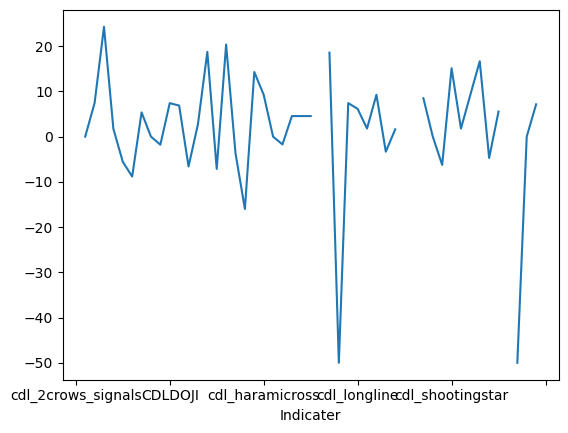

In [22]:
(50-df1["Win_Rate"]).plot()

In [41]:
ls=df1[df1.Return<0].index

In [42]:
ls

Index(['cdl_morningstar', 'cdl_separatinglines'], dtype='object', name='Indicater')

'sma_8'

In [45]:
pf_vbt.total_return()[3]

0.006233577254740085

In [46]:
pf_vbt.total_return()

sma_2     0.006007
sma_4    -0.007201
sma_6     0.000422
sma_8     0.006234
sma_10    0.003143
sma_12   -0.001770
sma_14    0.000458
sma_16   -0.005549
sma_18   -0.004590
Name: total_return, dtype: float64

250

Optimal value of 'a': 1
Optimal total return: -1.00%


In [34]:
signal=Optimizable_indicater(data.copy(),dic)

In [35]:
dict_1={"Indicater":[],"Return":[],"Win_Rate":[],"Sharp_ratio":[],"Trades":[]}
for i in signal.columns:
    pos=signal[i]
    data_1m['pos']=0
    idx=data_1m.loc[data_1m.index.isin(data.index)].index
    data_1m.loc[idx,'pos']=pos.loc[idx]
    pf_vbt = vbt.Portfolio.from_signals(data_1m.Close, low=data_1m.Low, high=data_1m.High,
                                               open=data_1m.Open, entries=data_1m.pos == 1, short_entries=data_1m.pos == -1,
                                               sl_stop=0.02, tp_stop=0.021,
                                               init_cash=100000, freq='1m')
    stat=pf_vbt.stats()
    dict_1['Indicater'].append(i)
    dict_1['Return'].append(stat['Total Return [%]'])
    dict_1['Win_Rate'].append(stat['Win Rate [%]'])
    dict_1["Sharp_ratio"].append(stat['Sharpe Ratio'])
    dict_1['Trades'].append(stat['Total Trades'])
    gc.collect()
df1=pd.DataFrame(dict_1)
df1.set_index("Indicater",inplace=True)
df1

,Return,Win_Rate,Sharp_ratio,Trades
Indicater,,,,
adx,-24.812672,41.250000,-5.283515,80
apo,-8.743934,37.450199,-1.148634,252
aroonosc,84.128561,61.294416,10.327263,2365
atr,0.203718,48.821549,0.408978,892
avgprice,129.618889,62.668732,13.900951,4520
bbands,18.985316,66.968326,3.479986,222
beta,-5.333049,51.826484,-0.516619,877
bop,149.463958,63.522976,15.226373,4571
cci_signals,215.135675,64.245810,19.068961,3760


<Axes: xlabel='Indicater'>

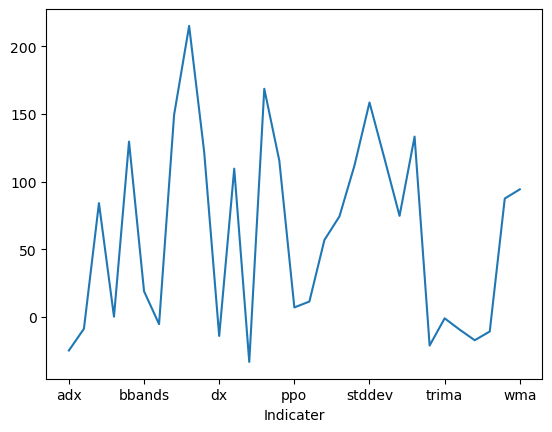

In [37]:
df1.Return.plot()

In [42]:
dict_2={"vote":[],"Return":[],"Win_Rate":[],"Sharp_ratio":[],"Trades":[]}
for i in range(1,25,2):
    pos=signal.sum(axis=1)
    data_1m['pos']=0
    idx=data_1m.loc[data_1m.index.isin(data.index)].index
    data_1m.loc[idx,'pos']=pos.loc[idx]
    pf_vbt = vbt.Portfolio.from_signals(data_1m.Close, low=data_1m.Low, high=data_1m.High,
                                               open=data_1m.Open, entries=data_1m.pos == i, short_entries=data_1m.pos == -i,
                                               sl_stop=0.02, tp_stop=0.021,
                                               init_cash=100000, freq='1m')
    stat=pf_vbt.stats()
    dict_2['vote'].append(i)
    dict_2['Return'].append(stat['Total Return [%]'])
    dict_2['Win_Rate'].append(stat['Win Rate [%]'])
    dict_2["Sharp_ratio"].append(stat['Sharpe Ratio'])
    dict_2['Trades'].append(stat['Total Trades'])
    gc.collect()
df2=pd.DataFrame(dict_2)
df2.set_index("vote",inplace=True)
df2

,Return,Win_Rate,Sharp_ratio,Trades
vote,,,,
1,-17.901145,48.858447,-3.608717,220
3,-7.122799,48.557692,-1.123954,209
5,4.117639,50.980392,1.102879,256
7,5.934218,53.947368,1.437645,229
9,-11.148119,55.938697,-2.001657,262
11,12.411156,56.106870,2.593975,263
13,-19.077807,54.032258,-3.875820,249
15,16.194811,57.916667,3.113513,241
17,-4.391049,58.433735,-0.559206,167


In [191]:
signal=pd.DataFrame()
signal.index=data.index
apo = talib.APO(data['Close'], fastperiod=2, slowperiod=20, matype=0)
signal['apo'] = np.where(apo > 100, 1, np.where(apo < -100, -1, 0))
atr = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
signal['atr']=np.where(data['Close'] > (data['High'].shift(1) + atr * 1.5), 1, np.where(data['Close'] < (data['Low'].shift(1) - atr * 1.5), -1, 0))
bbands_upper, _, bbands_Lower = talib.BBANDS(data['Close'], timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
signal['bbands']=np.where(data['Close'] < bbands_Lower, -1, 0) +  np.where(data['Close'] > bbands_upper, 1, 0)
cci = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=22)
signal["cci_signals"] = np.where(cci > 301, 1, np.where(cci< -301, -1, 0))
cdl_3inside = talib.CDL3INSIDE(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_3inside_signals'] = np.where(cdl_3inside > 0, 1, np.where(cdl_3inside < 0, -1, 0))
cdl_3linestrike = talib.CDL3LINESTRIKE(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_3linestrike']=np.where(cdl_3linestrike>0,-1,np.where(cdl_3linestrike<0,1,0))
cdl_belthold = talib.CDLBELTHOLD(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_belthold']=np.where(cdl_belthold>0,1,np.where(cdl_belthold<0,-1,0))
cdl_closingmarubozu = talib.CDLCLOSINGMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_closingmarubozu']=np.where(cdl_closingmarubozu>0,1,np.where(cdl_closingmarubozu<0,-1,0))
cdl_engulfing = talib.CDLENGULFING(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_engulfing']=np.where(cdl_engulfing>0,1,np.where(cdl_engulfing<0,-1,0))
cdl_longline = talib.CDLLONGLINE(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_longline']=np.where(cdl_longline>0,1,np.where(cdl_longline<0,-1,0))
cdl_marubozu = talib.CDLMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
signal['cdl_marubozu']=np.where(cdl_marubozu>0,1,np.where(cdl_marubozu<0,-1,0))
roc = talib.ROC(data['Close'], timeperiod=2)
signal['roc'] = np.where(roc > 1, 1, np.where(roc < -1, -1, 0))
rocp = talib.ROCP(data['Close'], timeperiod=31)
signal['rocp'] = np.where(rocp > 0.02, 1, np.where(rocp < -0.02, -1, 0))
rocr = talib.ROCR(data['Close'], timeperiod=30)
signal['rocr'] = np.where(rocr > 1.02, 1, np.where(rocr < 0.98, -1, 0))
rsi = talib.RSI(data['Close'], timeperiod=23)
signal['rsi'] = np.where(rsi > 70, 1, np.where(rsi < 30, -1, 0))
sar = talib.SAR(data['High'], data['Low'], acceleration=0.02, maximum=0.3)
signal['sar'] = np.where(data['Close'] > 1.02*sar, 1,np.where( data['Close'] < 0.98*sar,-1,0))
sma_14 = talib.SMA(data['Close'], timeperiod=14)
signal['sma_14'] = np.where((data['Close'] > sma_14)&(data.Close.shift(1)<=(data.Close)), 1, np.where((data['Close'] < sma_14) & (data.Close.shift(1)>=(data.Close)), -1, 0))
stddev = talib.STDDEV(data['Close'], timeperiod=3, nbdev=1)
signal['stddev'] = np.where(((stddev/data.Close)>0.006)&(data.Close>data.Close.shift(1)), 1, np.where(((stddev/data.Close)>0.006) & (data.Close<data.Close.shift(1)),-1, 0))
stochf_fastk, stochf_fastd = talib.STOCHF(data['High'], data['Low'], data['Close'], fastk_period=5, fastd_period=3, fastd_matype=0)
signal['stochf_fastk'] = np.where((stochf_fastk > stochf_fastd) & (stochf_fastk.shift(1) <= stochf_fastd.shift(1)), 1, np.where((stochf_fastk < stochf_fastd) & (stochf_fastk.shift(1) >= stochf_fastd.shift(1)), -1, 0))
stochrsi_fastk, stochrsi_fastd = talib.STOCHRSI(data['Close'], timeperiod=7, fastk_period=5, fastd_period=3, fastd_matype=0)
signal['stochrsi_fastk'] = np.where((stochrsi_fastk > stochrsi_fastd) & (stochrsi_fastk.shift(1) <= stochrsi_fastd.shift(1)), 1, np.where((stochrsi_fastk < stochrsi_fastd) & (stochrsi_fastk.shift(1) >= stochrsi_fastd.shift(1)), -1, 0))
t3 = talib.T3(data['Close'], timeperiod=5, vfactor=0)
signal['t3'] = np.where(data['Close'] > 1.01*t3, 1, np.where(data['Close'] < 0.99*t3, -1, 0))
tema = talib.TEMA(data['Close'], timeperiod=50)
signal['tema'] = np.where(data['Close'] > 1.01*tema, 1, np.where(data['Close'] < 0.99*tema, -1, 0))
trima = talib.TRIMA(data['Close'], timeperiod=5)
signal['trima'] = np.where(data['Close'] > 1.01*trima, 1, np.where(data['Close'] < 0.99*trima, -1, 0))
trix = talib.TRIX(data['Close'], timeperiod=5)
signal['trix'] = np.where((trix > 0.15)&(data.Close.rolling(14).mean()<data.Close), 1, np.where((trix < -0.15) & (data.Close.rolling(14).mean()>data.Close), -1, 0))
tsf = talib.TSF(data['Close'], timeperiod=24)
signal['tsf'] = np.where(data['Close'] > 1.01*tsf, 1, np.where(data['Close'] < 0.99*tsf, -1, 0))
typprice = talib.TYPPRICE(data['High'], data['Low'], data['Close'])
signal['typprice'] = np.where(typprice > 1.01*typprice.shift(1), 1, np.where(typprice < 0.99*typprice.shift(1), -1, 0))
ultosc = talib.ULTOSC(data['High'], data['Low'], data['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
signal['ultosc'] = np.where(ultosc > 1.27*ultosc.shift(1), 1, np.where(ultosc < 0.73*ultosc.shift(1), -1, 0))
wclprice = talib.WCLPRICE(data['High'], data['Low'], data['Close'])
signal['wclprice'] = np.where(wclprice > 1.01*wclprice.shift(1), 1, np.where(wclprice < 0.99*wclprice.shift(1), -1, 0))
willr = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=4)
signal['willr']= np.where(willr > -20, 1, np.where(willr < -80, -1, 0))
wma = talib.WMA(data['Close'], timeperiod=17)
signal['wma'] = np.where(data['Close'] > 1.01*wma, 1, np.where(data['Close'] < 0.99*wma, -1, 0))
def One_trade_only(df,sig,req_vote=1,min_hour=0,max_hour=23):
    final_df=pd.DataFrame(np.array(sig))
    final_df.index=df.index
    final_df.rename(columns={0:'sig'},inplace=True)
    final_df["zero"]=0
    start=final_df.index[0]
    end=final_df.index[-1]
    for ind in pd.date_range(start,end+timedelta(days=0)):
        d=final_df.loc[str(ind.date())]
        if  len(d)!=0:
            bear=(d.index[(d.sig<=(-req_vote))&(d.index.hour>=min_hour)&(d.index.hour<=max_hour)])
            bull=(d.index[(d.sig>=req_vote)&(d.index.hour>=min_hour)&(d.index.hour<=max_hour)])
            if (len(bear)!=0) & (len(bull)!=0):
                if bull[0]<bear[0]:
                    final_df.loc[bull[0],"zero"]=1
                elif bear[0]<bull[0]:
                    final_df.loc[bear[0],"zero"]=-1   
            elif len(bear)!=0:
                final_df.loc[bear[0],'zero']=-1
            elif len(bull)!=0:
                final_df.loc[bull[0],'zero']=1
    return((final_df.zero))

<Axes: xlabel='date'>

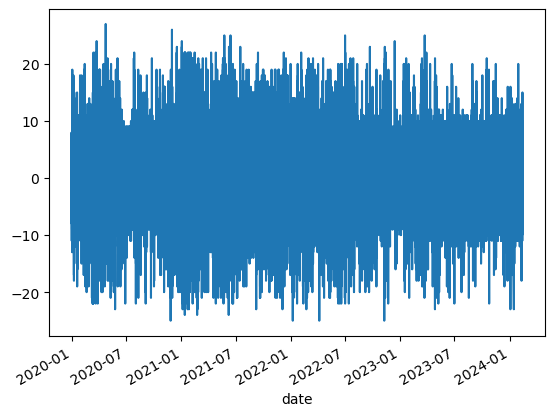

In [195]:
signal.sum(axis=1).plot()

# Test strategy

In [200]:
pos=(One_trade_only(data,signal.sum(axis=1),req_vote=1))
data_1m['pos']=0
idx=data_1m.loc[data_1m.index.isin(data.index)].index
data_1m.loc[idx,'pos']=pos.loc[idx]
pf_vbt = vbt.Portfolio.from_signals(data_1m.Close, low=data_1m.Low, high=data_1m.High,
                                               open=data_1m.Open, entries=data_1m.pos == 1, short_entries=data_1m.pos == -1,
                                               sl_stop=0.01, tp_stop=0.012,
                                               init_cash=100, freq='1m')
pf_vbt.stats()

Start                               2020-01-01 00:01:00
End                                 2024-02-12 23:59:00
Period                               1498 days 23:34:00
Start Value                                       100.0
End Value                                     76.124321
Total Return [%]                             -23.875679
Benchmark Return [%]                         595.322475
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              49.859685
Max Drawdown Duration                1488 days 22:10:00
Total Trades                                       1420
Total Closed Trades                                1420
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  44.929577
Best Trade [%]                                      1.2
Worst Trade [%]                                 

In [77]:
import backtesting as bt

C:\Users\shiv\anaconda3\envs\pt\lib\site-packages\backtesting\_plotting.py:50: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

In [88]:
class Strategy(bt.Strategy):
    def init(self):
        
        return
    def next(self):
        if len(self.data.df)>18:
            data=self.data.df[-17:]
            price=data.Close[-1]
            atr = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
            pos=np.where(data['Close'] > (data['High'].shift(1) + atr * 1.5), 1, np.where(data['Close'] < (data['Low'].shift(1) - atr * 1.5), -1, 0))[-1]
            target=1.01
            loss=0.99
            if ((pos==1) | (pos==-1)) & ((self.position.is_short==True) | (self.position.is_long==True)):
                self.position.close()
        
            if (pos==1) & (self.position.is_short==False) & (self.position.is_long==False):
                self.buy(sl=loss*price,tp=target*price)
            elif (pos==-1)&(self.position.is_long==False) & (self.position.is_short==False):
                self.sell(sl=target*price,tp=loss*price)
        else:
            print("less than 14")
            
        return 
pf=bt.Backtest(data,Strategy,trade_on_close=True,cash=100000)
pf_data=pf.run()
pf_data#10.00

less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14
less than 14


Start                     2020-01-01 00:00:00
End                       2024-02-12 23:55:00
Duration                   1503 days 23:55:00
Exposure Time [%]                   34.727148
Equity Final [$]                   41686.3308
Equity Peak [$]                   122448.7257
Return [%]                         -58.313669
Buy & Hold Return [%]               595.68684
Return (Ann.) [%]                  -18.870307
Volatility (Ann.) [%]               19.630562
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -65.973757
Avg. Drawdown [%]                   -1.987011
Max. Drawdown Duration     1295 days 00:40:00
Avg. Drawdown Duration       19 days 11:22:00
# Trades                                 5737
Win Rate [%]                        49.050026
Best Trade [%]                            1.0
Worst Trade [%]                          -1.0
Avg. Trade [%]                    

In [ ]:
atr = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
pos=np.where(data['Close'] > (data['High'].shift(1) + atr * 1.5), 1, np.where(data['Close'] < (data['Low'].shift(1) - atr * 1.5), -1, 0))[-1]

In [86]:
spt_data=data_1m.iloc[100000:]

In [142]:
dd.groupby(pd.Grouper(freq="5Min")).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

,Open,High,Low,Close,Volume
date,,,,,
2024-02-12 23:35:00,49964.84,49965.95,49960.00,49965.95,12.76352
2024-02-12 23:40:00,49965.94,50014.67,49936.40,50010.86,121.51591
2024-02-12 23:45:00,50010.85,50024.40,49976.52,49999.80,72.39134
2024-02-12 23:50:00,49999.81,50025.35,49999.80,50023.83,25.03228


In [162]:

dd=data_1m.loc['2024-02-12 22:35:00':'2024-02-12 23:40:00']
dd

,Open,High,Low,Close,Volume
date,,,,,
2024-02-12 22:35:00,49943.94,49943.95,49943.94,49943.95,5.66481
2024-02-12 22:36:00,49943.95,49963.02,49943.94,49963.01,11.58697
2024-02-12 22:37:00,49963.02,49966.34,49958.89,49958.89,10.35603
2024-02-12 22:38:00,49958.89,49958.90,49956.66,49956.67,10.20687
2024-02-12 22:39:00,49956.66,50015.70,49956.66,50015.69,23.15941
...,...,...,...,...,...
2024-02-12 23:36:00,49991.10,49994.43,49987.33,49989.91,19.33678
2024-02-12 23:37:00,49989.91,49989.91,49971.38,49972.08,28.86649
2024-02-12 23:38:00,49972.09,49972.09,49964.84,49964.85,8.20044


In [163]:
rr=dd.resample('5T',closed='right').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})
rr.index=rr.index+timedelta(minutes=5)
rr

,Open,High,Low,Close,Volume
date,,,,,
2024-02-12 22:35:00,49943.94,49943.95,49943.94,49943.95,5.66481
2024-02-12 22:40:00,49943.95,50066.08,49943.94,50016.52,89.26263
2024-02-12 22:45:00,50016.51,50065.65,50016.51,50044.99,74.03820
2024-02-12 22:50:00,50045.00,50054.02,50023.23,50023.24,55.17825
2024-02-12 22:55:00,50023.23,50023.24,49933.02,49976.65,103.40648
2024-02-12 23:00:00,49976.65,50036.80,49976.65,49982.65,84.45520
2024-02-12 23:05:00,49982.65,50043.92,49950.04,49953.37,176.36359
2024-02-12 23:10:00,49953.38,49989.20,49931.10,49964.33,105.40732
2024-02-12 23:15:00,49964.34,49977.54,49905.77,49907.60,115.66061


<Axes: xlabel='date'>

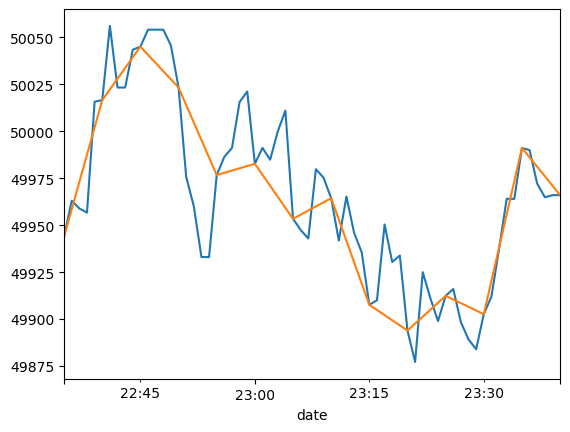

In [164]:
dd.Close.plot()
rr.Close.plot()

In [ ]:
                 50019.99	                        50007.49	

# Run Below Line For See Performance of each indicater

# Run Below For See Performance At Each voting Number

In [27]:
dict_2={"Indicater":[],"Return":[],"Win_Rate":[],"Sharp_ratio":[],"Trades":[]}
for i in range(1,46,2):
    pos=(One_trade_only(data,signal[(list(df1[df1.Return>500].index))].sum(axis=1),req_vote=i))
    data_1m['pos']=0
    idx=data_1m.loc[data_1m.index.isin(data.index)].index
    data_1m.loc[idx,'pos']=pos.loc[idx]
    pf_vbt = vbt.Portfolio.from_signals(data_1m.Close, low=data_1m.Low, high=data_1m.High,
                                               open=data_1m.Open, entries=data_1m.pos == 1, short_entries=data_1m.pos == -1,
                                               sl_stop=0.01, tp_stop=0.011,
                                               init_cash=100000, freq='1m')
    stat=pf_vbt.stats()
    dict_2['Indicater'].append(i)
    dict_2['Return'].append(stat['Total Return [%]'])
    dict_2['Win_Rate'].append(stat['Win Rate [%]'])
    dict_2["Sharp_ratio"].append(stat['Sharpe Ratio'])
    dict_2['Trades'].append(stat['Total Trades'])
    gc.collect()
df2=pd.DataFrame(dict_2)
df2.set_index("Indicater",inplace=True)
df2

,Return,Win_Rate,Sharp_ratio,Trades
Indicater,,,,
1,349.638169,53.003534,2.018192,1415
3,1097.884010,56.345886,3.262252,1434
5,2330.380216,58.582349,4.174699,1439
7,3529.556486,59.916493,4.623417,1437
9,15382.514682,65.072464,6.751008,1380
11,34521.564325,78.275109,9.751526,916
13,16498.665850,83.381924,10.110440,686
15,8575.271288,88.380952,10.340067,525
17,3900.079088,93.059126,10.075273,389


In [23]:

fig2 = px.line(df2, title='Performance at different vote ')
fig2.update_layout(xaxis_title='required_vote')
fig2.show()


In [37]:
df2

,Return,Win_Rate,Sharp_ratio,Trades
Indicater,,,,
1,349.638169,53.003534,2.018192,1415
3,1097.884010,56.345886,3.262252,1434
5,2330.380216,58.582349,4.174699,1439
7,3529.556486,59.916493,4.623417,1437
9,15382.514682,65.072464,6.751008,1380
11,34521.564325,78.275109,9.751526,916
13,16498.665850,83.381924,10.110440,686
15,8575.271288,88.380952,10.340067,525
17,3900.079088,93.059126,10.075273,389


In [48]:
len(list(df1[df1.Return>500].index))

30